# Revenue Forecasting ML Pipeline
## Human Forecast Validator System

**Objective:** Replace manual analyst work with a validated ML system for revenue forecasting

**Features:**
- Wtd. pipeline → POC stage (50%)
- Committed → unsigned (100%)
- Committed → signed (after the final)

**Data Split:**
- Train: 2023-2024
- Test: 2025

**Target:** MAPE < 1%

---
## STEP 1: Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

# Feature Selection
from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_regression,
    RFE, RFECV, VarianceThreshold, SelectFromModel
)

# Models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor,
    StackingRegressor, BaggingRegressor
)
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, LinearRegression,
    HuberRegressor, BayesianRidge
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# XGBoost & LightGBM
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Install with: pip install xgboost")

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed. Install with: pip install lightgbm")

# Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, median_absolute_error
)

# Statistical tests
from scipy import stats
from scipy.stats import shapiro, normaltest, spearmanr, pearsonr

print("✓ All libraries imported successfully")
print(f"  XGBoost available: {XGBOOST_AVAILABLE}")
print(f"  LightGBM available: {LIGHTGBM_AVAILABLE}")

✓ All libraries imported successfully
  XGBoost available: True
  LightGBM available: True


---
## STEP 2: Load and Explore Data

In [6]:
# Load data - UPDATE THIS PATH TO YOUR CSV FILE
df = pd.read_csv('df_monthlyy.csv')

print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:")
df.head()

DATA OVERVIEW

Shape: (33, 8)

Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct']

Data Types:
year                         int64
month                       object
month_num                    int64
actual_revenue             float64
wtd_pipeline_revenue       float64
committed_unsig_revenue    float64
committed_sign_revenue     float64
avg_prob_pct               float64
dtype: object

Missing Values:
year                       0
month                      0
month_num                  0
actual_revenue             0
wtd_pipeline_revenue       0
committed_unsig_revenue    0
committed_sign_revenue     0
avg_prob_pct               0
dtype: int64

First 5 rows:


,year,month,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct
0,2023,Mar,3,1.436527e+08,3956583.64,18387583.42,1.193411e+08,0.52
1,2023,Apr,4,1.248860e+08,3648496.26,18456403.04,1.075582e+08,0.33
2,2023,May,5,1.388757e+08,2204570.93,11435574.21,1.238348e+08,0.34
3,2023,Jun,6,1.412344e+08,3325963.87,13171199.32,1.230538e+08,0.33
4,2023,Jul,7,1.296316e+08,2218376.60,20878851.78,1.071785e+08,0.33


In [7]:
# Statistical summary
print("="*60)
print("STATISTICAL SUMMARY")
print("="*60)
df.describe()

STATISTICAL SUMMARY


,year,month_num,actual_revenue,wtd_pipeline_revenue,committed_unsig_revenue,committed_sign_revenue,avg_prob_pct
count,33.000000,33.000000,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,33.000000
mean,2024.030303,6.636364,1.550576e+08,2.840896e+06,1.242116e+07,1.397845e+08,1.127879
std,0.809508,3.296003,1.600101e+07,1.052766e+06,3.456509e+06,1.816499e+07,1.527964
min,2023.000000,1.000000,1.248860e+08,9.761975e+05,6.001370e+06,1.071785e+08,0.160000
25%,2023.000000,4.000000,1.412344e+08,2.204571e+06,1.022060e+07,1.238348e+08,0.330000
50%,2024.000000,7.000000,1.561137e+08,2.662105e+06,1.170021e+07,1.399337e+08,0.370000
75%,2025.000000,9.000000,1.706813e+08,3.325964e+06,1.374208e+07,1.555049e+08,0.810000
max,2025.000000,12.000000,1.843241e+08,6.327879e+06,2.087885e+07,1.719981e+08,4.550000


In [8]:
# Check data by year
print("="*60)
print("DATA BY YEAR")
print("="*60)
print(df.groupby('year').agg({
    'actual_revenue': ['count', 'sum', 'mean', 'std'],
    'committed_sign_revenue': ['sum', 'mean'],
    'committed_unsig_revenue': ['sum', 'mean'],
    'wtd_pipeline_revenue': ['sum', 'mean']
}))

DATA BY YEAR
     actual_revenue                                            \
              count           sum          mean           std   
year                                                            
2023             10  1.373678e+09  1.373678e+08  6.168852e+06   
2024             12  1.838372e+09  1.531976e+08  7.675182e+06   
2025             11  1.904853e+09  1.731685e+08  6.509250e+06   

     committed_sign_revenue               committed_unsig_revenue  \
                        sum          mean                     sum   
year                                                                
2023           1.189730e+09  1.189730e+08            1.573101e+08   
2024           1.660953e+09  1.384127e+08            1.422748e+08   
2025           1.762207e+09  1.602006e+08            1.103135e+08   

                   wtd_pipeline_revenue                
              mean                  sum          mean  
year                                                   
2023  1.57310

---
## STEP 3: Data Visualization - Raw Data Analysis

In [9]:
# Create date index for plotting
df_monthly = df.copy()

# Create a proper date column
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
             'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

if 'month' in df_monthly.columns:
    df_monthly['month_num_parsed'] = df_monthly['month'].map(month_map)
    if df_monthly['month_num_parsed'].isnull().any():
        df_monthly['month_num_parsed'] = df_monthly['month_num']
else:
    df_monthly['month_num_parsed'] = df_monthly['month_num']

df_monthly['date'] = pd.to_datetime(
    df_monthly['year'].astype(str) + '-' + df_monthly['month_num_parsed'].astype(str) + '-01'
)

df_monthly = df_monthly.sort_values('date').reset_index(drop=True)
print(f"Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")

Date range: 2023-03-01 00:00:00 to 2025-11-01 00:00:00


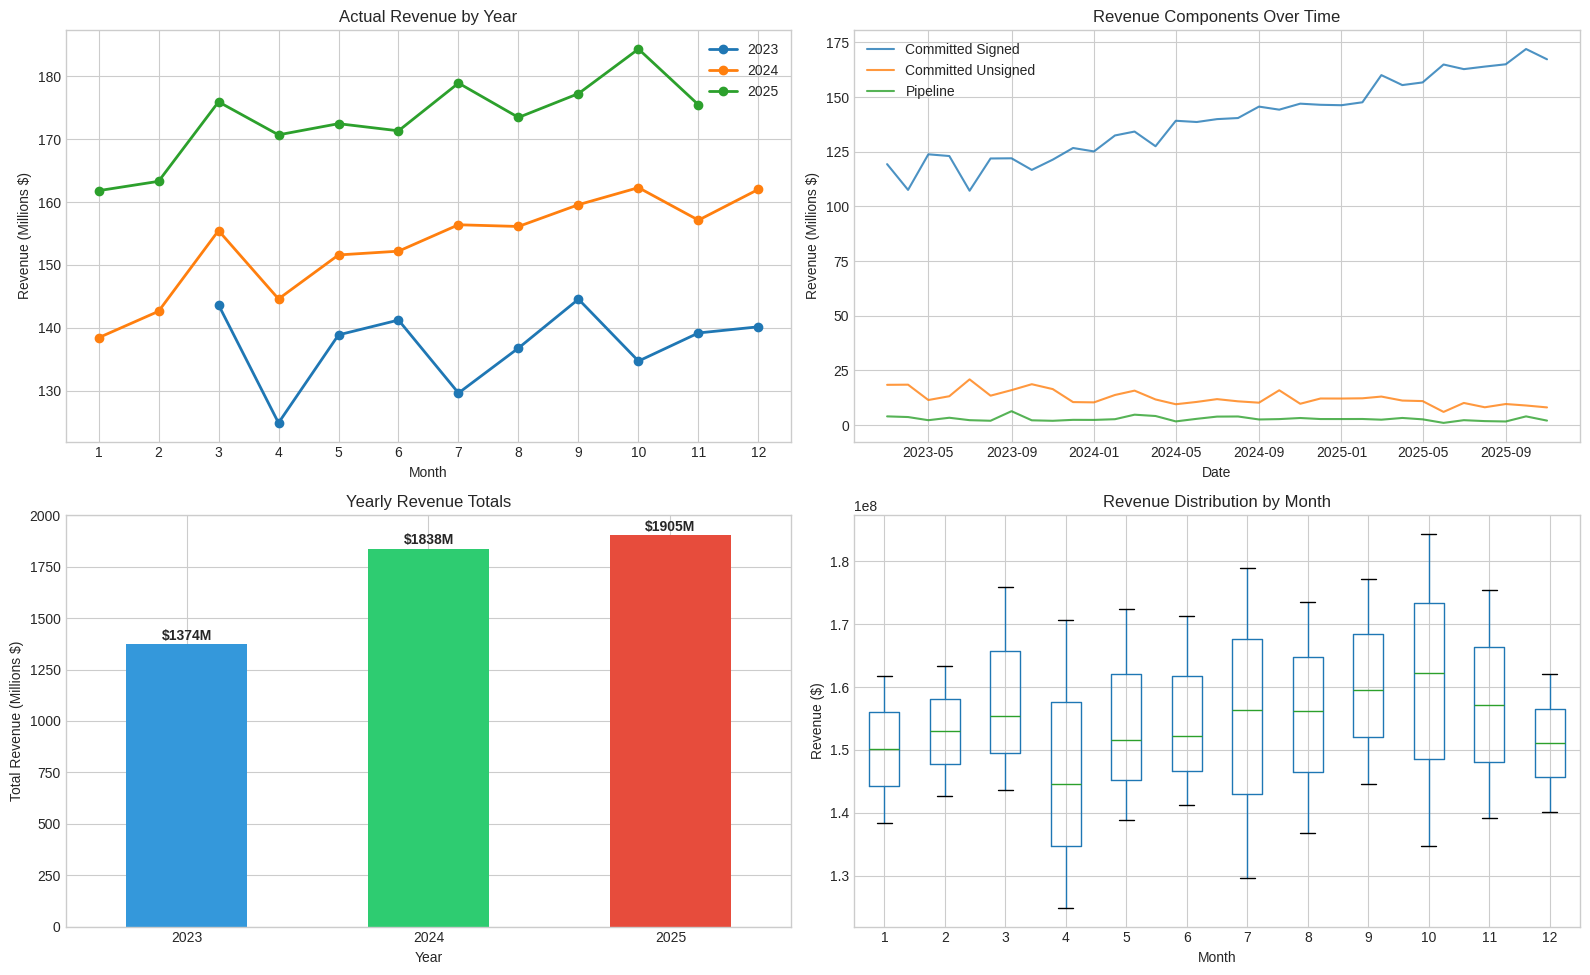

In [10]:
# Plot revenue trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Actual Revenue over time
ax1 = axes[0, 0]
for year in df_monthly['year'].unique():
    year_data = df_monthly[df_monthly['year'] == year]
    ax1.plot(year_data['month_num_parsed'], year_data['actual_revenue']/1e6,
             marker='o', label=str(year), linewidth=2)
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (Millions $)')
ax1.set_title('Actual Revenue by Year')
ax1.legend()
ax1.set_xticks(range(1, 13))

# 2. Revenue Components
ax2 = axes[0, 1]
ax2.plot(df_monthly['date'], df_monthly['committed_sign_revenue']/1e6,
         label='Committed Signed', alpha=0.8)
ax2.plot(df_monthly['date'], df_monthly['committed_unsig_revenue']/1e6,
         label='Committed Unsigned', alpha=0.8)
ax2.plot(df_monthly['date'], df_monthly['wtd_pipeline_revenue']/1e6,
         label='Pipeline', alpha=0.8)
ax2.set_xlabel('Date')
ax2.set_ylabel('Revenue (Millions $)')
ax2.set_title('Revenue Components Over Time')
ax2.legend()

# 3. Year over Year Growth
ax3 = axes[1, 0]
yearly_revenue = df_monthly.groupby('year')['actual_revenue'].sum()/1e6
yearly_revenue.plot(kind='bar', ax=ax3, color=['#3498db', '#2ecc71', '#e74c3c'])
ax3.set_xlabel('Year')
ax3.set_ylabel('Total Revenue (Millions $)')
ax3.set_title('Yearly Revenue Totals')
ax3.tick_params(axis='x', rotation=0)

# Add growth percentage
for i, (year, rev) in enumerate(yearly_revenue.items()):
    ax3.text(i, rev + 20, f'${rev:.0f}M', ha='center', fontweight='bold')

# 4. Monthly Distribution
ax4 = axes[1, 1]
df_monthly.boxplot(column='actual_revenue', by='month_num_parsed', ax=ax4)
ax4.set_xlabel('Month')
ax4.set_ylabel('Revenue ($)')
ax4.set_title('Revenue Distribution by Month')
plt.suptitle('')

plt.tight_layout()
plt.savefig('revenue_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 4: Advanced Feature Engineering

In [11]:
print("="*60)
print("FEATURE ENGINEERING - PHASE 1: BASE FEATURES")
print("="*60)

# 4.1 Quarter Features
df_monthly['quarter'] = ((df_monthly['month_num_parsed'] - 1) // 3) + 1
df_monthly['is_q1'] = (df_monthly['quarter'] == 1).astype(int)
df_monthly['is_q2'] = (df_monthly['quarter'] == 2).astype(int)
df_monthly['is_q3'] = (df_monthly['quarter'] == 3).astype(int)
df_monthly['is_q4'] = (df_monthly['quarter'] == 4).astype(int)
print("✓ Quarter indicators created")

# 4.2 Month Position Features
df_monthly['is_year_start'] = (df_monthly['month_num_parsed'] <= 3).astype(int)
df_monthly['is_year_end'] = (df_monthly['month_num_parsed'] >= 10).astype(int)
df_monthly['is_mid_year'] = ((df_monthly['month_num_parsed'] >= 5) &
                              (df_monthly['month_num_parsed'] <= 8)).astype(int)
print("✓ Month position features created")

# 4.3 Cyclical Features (encode month as sin/cos for continuity)
df_monthly['month_sin'] = np.sin(2 * np.pi * df_monthly['month_num_parsed'] / 12)
df_monthly['month_cos'] = np.cos(2 * np.pi * df_monthly['month_num_parsed'] / 12)
df_monthly['quarter_sin'] = np.sin(2 * np.pi * df_monthly['quarter'] / 4)
df_monthly['quarter_cos'] = np.cos(2 * np.pi * df_monthly['quarter'] / 4)
print("✓ Cyclical features created")

# 4.4 Quarter Progress
df_monthly['month_in_quarter'] = ((df_monthly['month_num_parsed'] - 1) % 3) + 1
df_monthly['is_quarter_start'] = (df_monthly['month_in_quarter'] == 1).astype(int)
df_monthly['is_quarter_end'] = (df_monthly['month_in_quarter'] == 3).astype(int)
print("✓ Quarter progress features created")

FEATURE ENGINEERING - PHASE 1: BASE FEATURES
✓ Quarter indicators created
✓ Month position features created
✓ Cyclical features created
✓ Quarter progress features created


In [12]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 2: LAG FEATURES")
print("="*60)

# 4.5 Lag Features - Committed Signed
for lag in [1, 2, 3, 6]:
    df_monthly[f'committed_sign_lag{lag}'] = df_monthly['committed_sign_revenue'].shift(lag)
print("✓ Committed signed lag features (1,2,3,6) created")

# 4.6 Lag Features - Committed Unsigned
for lag in [1, 2, 3]:
    df_monthly[f'committed_unsig_lag{lag}'] = df_monthly['committed_unsig_revenue'].shift(lag)
print("✓ Committed unsigned lag features (1,2,3) created")

# 4.7 Lag Features - Pipeline
for lag in [1, 2, 3, 6]:
    df_monthly[f'pipeline_lag{lag}'] = df_monthly['wtd_pipeline_revenue'].shift(lag)
print("✓ Pipeline lag features (1,2,3,6) created")

# 4.8 Lag Features - NOTE: avg_prob_pct is a GUESS column, so we only use its lags
# We do NOT create interaction features with avg_prob_pct as per business constraint
df_monthly['prob_lag1'] = df_monthly['avg_prob_pct'].shift(1)
df_monthly['prob_lag2'] = df_monthly['avg_prob_pct'].shift(2)
print("✓ Probability lag features created (note: avg_prob_pct interactions excluded)")


FEATURE ENGINEERING - PHASE 2: LAG FEATURES
✓ Committed signed lag features (1,2,3,6) created
✓ Committed unsigned lag features (1,2,3) created
✓ Pipeline lag features (1,2,3,6) created
✓ Probability lag features created (note: avg_prob_pct interactions excluded)


In [13]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 3: ROLLING STATISTICS")
print("="*60)

# 4.9 Rolling Mean - Committed Signed
for window in [3, 6, 12]:
    df_monthly[f'committed_sign_rolling_mean_{window}'] = \
        df_monthly['committed_sign_revenue'].rolling(window=window, min_periods=1).mean()
print("✓ Committed signed rolling means (3,6,12) created")

# 4.10 Rolling Std - Committed Signed
for window in [3, 6]:
    df_monthly[f'committed_sign_rolling_std_{window}'] = \
        df_monthly['committed_sign_revenue'].rolling(window=window, min_periods=1).std()
print("✓ Committed signed rolling std (3,6) created")

# 4.11 Rolling Mean - Committed Unsigned
for window in [3, 6]:
    df_monthly[f'committed_unsig_rolling_mean_{window}'] = \
        df_monthly['committed_unsig_revenue'].rolling(window=window, min_periods=1).mean()
print("✓ Committed unsigned rolling means (3,6) created")

# 4.12 Rolling Mean - Pipeline
for window in [3, 6, 12]:
    df_monthly[f'pipeline_rolling_mean_{window}'] = \
        df_monthly['wtd_pipeline_revenue'].rolling(window=window, min_periods=1).mean()
print("✓ Pipeline rolling means (3,6,12) created")

# 4.13 Rolling Std - Pipeline
df_monthly['pipeline_rolling_std_3'] = \
    df_monthly['wtd_pipeline_revenue'].rolling(window=3, min_periods=1).std()
df_monthly['pipeline_rolling_std_6'] = \
    df_monthly['wtd_pipeline_revenue'].rolling(window=6, min_periods=1).std()
print("✓ Pipeline rolling std (3,6) created")


FEATURE ENGINEERING - PHASE 3: ROLLING STATISTICS
✓ Committed signed rolling means (3,6,12) created
✓ Committed signed rolling std (3,6) created
✓ Committed unsigned rolling means (3,6) created
✓ Pipeline rolling means (3,6,12) created
✓ Pipeline rolling std (3,6) created


In [14]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 4: DERIVED FEATURES")
print("="*60)

# 4.14 Total Committed
df_monthly['total_committed'] = df_monthly['committed_sign_revenue'] + df_monthly['committed_unsig_revenue']
print("✓ Total committed created")

# 4.15 Ratio Features
df_monthly['committed_sign_ratio'] = df_monthly['committed_sign_revenue'] / (df_monthly['total_committed'] + 1)
df_monthly['pipeline_to_committed_ratio'] = df_monthly['wtd_pipeline_revenue'] / (df_monthly['total_committed'] + 1)
df_monthly['signed_unsigned_ratio'] = df_monthly['committed_sign_revenue'] / (df_monthly['committed_unsig_revenue'] + 1)
df_monthly['pipeline_to_signed_ratio'] = df_monthly['wtd_pipeline_revenue'] / (df_monthly['committed_sign_revenue'] + 1)
print("✓ Ratio features created")

# 4.16 Weighted Snapshot (business logic weights)
df_monthly['weighted_snapshot'] = (
    df_monthly['committed_sign_revenue'] * 1.0 +
    df_monthly['committed_unsig_revenue'] * 0.9 +
    df_monthly['wtd_pipeline_revenue'] * 0.5
)
print("✓ Weighted snapshot created")

# 4.17 Snapshot rolling
df_monthly['weighted_snapshot_rolling_mean_3'] = \
    df_monthly['weighted_snapshot'].rolling(window=3, min_periods=1).mean()
df_monthly['weighted_snapshot_rolling_mean_6'] = \
    df_monthly['weighted_snapshot'].rolling(window=6, min_periods=1).mean()
print("✓ Weighted snapshot rolling means created")


FEATURE ENGINEERING - PHASE 4: DERIVED FEATURES
✓ Total committed created
✓ Ratio features created
✓ Weighted snapshot created
✓ Weighted snapshot rolling means created


In [15]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 5: MOMENTUM & VOLATILITY")
print("="*60)

# 4.18 Momentum Indicators
df_monthly['committed_sign_momentum'] = df_monthly['committed_sign_revenue'] - df_monthly['committed_sign_lag1']
df_monthly['committed_unsig_momentum'] = df_monthly['committed_unsig_revenue'] - df_monthly['committed_unsig_lag1']
df_monthly['pipeline_momentum'] = df_monthly['wtd_pipeline_revenue'] - df_monthly['pipeline_lag1']
df_monthly['total_committed_momentum'] = df_monthly['total_committed'] - df_monthly['total_committed'].shift(1)
print("✓ Momentum indicators created")

# 4.19 Volatility Measures
df_monthly['committed_sign_volatility'] = df_monthly['committed_sign_revenue'].rolling(window=6, min_periods=1).std()
df_monthly['pipeline_volatility'] = df_monthly['wtd_pipeline_revenue'].rolling(window=6, min_periods=1).std()
df_monthly['total_committed_volatility'] = df_monthly['total_committed'].rolling(window=6, min_periods=1).std()
print("✓ Volatility measures created")

# 4.20 Percentage Changes
df_monthly['committed_sign_pct_change'] = df_monthly['committed_sign_revenue'].pct_change().fillna(0)
df_monthly['pipeline_pct_change'] = df_monthly['wtd_pipeline_revenue'].pct_change().fillna(0)
df_monthly['total_committed_pct_change'] = df_monthly['total_committed'].pct_change().fillna(0)
print("✓ Percentage change features created")

# 4.21 Acceleration (2nd derivative)
df_monthly['committed_sign_acceleration'] = df_monthly['committed_sign_momentum'] - \
    df_monthly['committed_sign_momentum'].shift(1)
df_monthly['pipeline_acceleration'] = df_monthly['pipeline_momentum'] - \
    df_monthly['pipeline_momentum'].shift(1)
print("✓ Acceleration features created")


FEATURE ENGINEERING - PHASE 5: MOMENTUM & VOLATILITY
✓ Momentum indicators created
✓ Volatility measures created
✓ Percentage change features created
✓ Acceleration features created


In [16]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 6: EXPONENTIAL MOVING AVERAGES")
print("="*60)

# 4.22 EMA - Committed Signed
for span in [3, 6, 12]:
    df_monthly[f'committed_sign_ema_{span}'] = \
        df_monthly['committed_sign_revenue'].ewm(span=span, adjust=False).mean()
print("✓ Committed signed EMA (3,6,12) created")

# 4.23 EMA - Pipeline
for span in [3, 6]:
    df_monthly[f'pipeline_ema_{span}'] = \
        df_monthly['wtd_pipeline_revenue'].ewm(span=span, adjust=False).mean()
print("✓ Pipeline EMA (3,6) created")

# 4.24 EMA - Total Committed
for span in [3, 6]:
    df_monthly[f'total_committed_ema_{span}'] = \
        df_monthly['total_committed'].ewm(span=span, adjust=False).mean()
print("✓ Total committed EMA (3,6) created")


FEATURE ENGINEERING - PHASE 6: EXPONENTIAL MOVING AVERAGES
✓ Committed signed EMA (3,6,12) created
✓ Pipeline EMA (3,6) created
✓ Total committed EMA (3,6) created


In [17]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 7: YEAR-OVER-YEAR")
print("="*60)

# 4.25 YoY Features
df_monthly['committed_sign_yoy'] = df_monthly['committed_sign_revenue'].shift(12)
df_monthly['committed_unsig_yoy'] = df_monthly['committed_unsig_revenue'].shift(12)
df_monthly['pipeline_yoy'] = df_monthly['wtd_pipeline_revenue'].shift(12)
df_monthly['total_committed_yoy'] = df_monthly['total_committed'].shift(12)
print("✓ YoY features created")

# 4.26 YoY Growth Rates
df_monthly['committed_sign_yoy_growth'] = (
    (df_monthly['committed_sign_revenue'] - df_monthly['committed_sign_yoy']) /
    (df_monthly['committed_sign_yoy'] + 1)
)
df_monthly['pipeline_yoy_growth'] = (
    (df_monthly['wtd_pipeline_revenue'] - df_monthly['pipeline_yoy']) /
    (df_monthly['pipeline_yoy'] + 1)
)
print("✓ YoY growth rates created")


FEATURE ENGINEERING - PHASE 7: YEAR-OVER-YEAR
✓ YoY features created
✓ YoY growth rates created


In [18]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 8: INTERACTION FEATURES")
print("="*60)

# 4.27 Probability Interactions
df_monthly['prob_x_committed_sign'] = df_monthly['avg_prob_pct'] * df_monthly['committed_sign_revenue']
df_monthly['prob_x_pipeline'] = df_monthly['avg_prob_pct'] * df_monthly['wtd_pipeline_revenue']
df_monthly['prob_x_total_committed'] = df_monthly['avg_prob_pct'] * df_monthly['total_committed']
df_monthly['prob_x_weighted_snapshot'] = df_monthly['avg_prob_pct'] * df_monthly['weighted_snapshot']
print("✓ Probability interaction features created")

# 4.28 Seasonal Interactions
df_monthly['committed_sign_x_quarter'] = df_monthly['committed_sign_revenue'] * df_monthly['quarter']
df_monthly['pipeline_x_quarter'] = df_monthly['wtd_pipeline_revenue'] * df_monthly['quarter']
df_monthly['committed_sign_x_month'] = df_monthly['committed_sign_revenue'] * df_monthly['month_num_parsed']
df_monthly['pipeline_x_month'] = df_monthly['wtd_pipeline_revenue'] * df_monthly['month_num_parsed']
print("✓ Seasonal interaction features created")


FEATURE ENGINEERING - PHASE 8: INTERACTION FEATURES
✓ Probability interaction features created
✓ Seasonal interaction features created


In [19]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 9: ADVANCED FEATURES")
print("="*60)

# 4.29 Trend Strength
df_monthly['committed_sign_trend_strength'] = (
    df_monthly['committed_sign_revenue'] - df_monthly['committed_sign_rolling_mean_3']
) / (df_monthly['committed_sign_rolling_mean_3'] + 1)

df_monthly['pipeline_trend_strength'] = (
    df_monthly['wtd_pipeline_revenue'] - df_monthly['pipeline_rolling_mean_3']
) / (df_monthly['pipeline_rolling_mean_3'] + 1)
print("✓ Trend strength features created")

# 4.30 Ratio Stability
df_monthly['ratio_stability'] = df_monthly['committed_sign_ratio'].rolling(window=3, min_periods=1).std()
df_monthly['pipeline_ratio_stability'] = df_monthly['pipeline_to_committed_ratio'].rolling(window=3, min_periods=1).std()
print("✓ Ratio stability features created")

# 4.31 Cumulative Features (Year-to-Date)
df_monthly['ytd_committed_sign'] = df_monthly.groupby('year')['committed_sign_revenue'].cumsum()
df_monthly['ytd_pipeline'] = df_monthly.groupby('year')['wtd_pipeline_revenue'].cumsum()
df_monthly['ytd_total_committed'] = df_monthly.groupby('year')['total_committed'].cumsum()
print("✓ Year-to-date cumulative features created")

# 4.32 Commitment Velocity
df_monthly['commitment_velocity'] = df_monthly['total_committed'] - df_monthly['total_committed'].shift(1)
df_monthly['commitment_velocity_3m_avg'] = df_monthly['commitment_velocity'].rolling(window=3, min_periods=1).mean()
print("✓ Commitment velocity features created")

# 4.33 Pipeline Flow
df_monthly['pipeline_to_committed_flow'] = df_monthly['total_committed'] - df_monthly['wtd_pipeline_revenue']
print("✓ Pipeline to committed flow feature created")

# 4.34 Growth Rate 3M
df_monthly['committed_sign_growth_rate_3m'] = (
    (df_monthly['committed_sign_revenue'] - df_monthly['committed_sign_lag3']) /
    (df_monthly['committed_sign_lag3'] + 1)
)
print("✓ 3-month growth rate created")

# 4.35 Lead Indicators
df_monthly['pipeline_lead_2m'] = df_monthly['wtd_pipeline_revenue'].shift(2)
df_monthly['pipeline_lead_3m'] = df_monthly['wtd_pipeline_revenue'].shift(3)
df_monthly['committed_sign_lead_2m'] = df_monthly['committed_sign_revenue'].shift(2)
print("✓ Lead indicator features created")


FEATURE ENGINEERING - PHASE 9: ADVANCED FEATURES
✓ Trend strength features created
✓ Ratio stability features created
✓ Year-to-date cumulative features created
✓ Commitment velocity features created
✓ Pipeline to committed flow feature created
✓ 3-month growth rate created
✓ Lead indicator features created


In [20]:
print("\n" + "="*60)
print("FEATURE ENGINEERING - PHASE 10: SEASONAL FACTORS")
print("="*60)

# 4.36 Seasonal Factors (relative to monthly average)
month_avg_committed = df_monthly.groupby('month_num_parsed')['committed_sign_revenue'].transform('mean')
df_monthly['committed_seasonal_factor'] = df_monthly['committed_sign_revenue'] / (month_avg_committed + 1)

month_avg_pipeline = df_monthly.groupby('month_num_parsed')['wtd_pipeline_revenue'].transform('mean')
df_monthly['pipeline_seasonal_factor'] = df_monthly['wtd_pipeline_revenue'] / (month_avg_pipeline + 1)
print("✓ Seasonal factor features created")

# 4.37 Quarterly Averages
quarter_avg_committed = df_monthly.groupby('quarter')['committed_sign_revenue'].transform('mean')
df_monthly['committed_quarter_factor'] = df_monthly['committed_sign_revenue'] / (quarter_avg_committed + 1)
print("✓ Quarter factor features created")


FEATURE ENGINEERING - PHASE 10: SEASONAL FACTORS
✓ Seasonal factor features created
✓ Quarter factor features created


In [21]:
# Fill NaN values
df_monthly = df_monthly.fillna(0)

# Replace infinite values
df_monthly = df_monthly.replace([np.inf, -np.inf], 0)

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"\nTotal features created: {len(df_monthly.columns)}")
print(f"\nColumn list:")
for i, col in enumerate(df_monthly.columns, 1):
    print(f"  {i:3d}. {col}")


FEATURE ENGINEERING COMPLETE

Total features created: 108

Column list:
    1. year
    2. month
    3. month_num
    4. actual_revenue
    5. wtd_pipeline_revenue
    6. committed_unsig_revenue
    7. committed_sign_revenue
    8. avg_prob_pct
    9. month_num_parsed
   10. date
   11. quarter
   12. is_q1
   13. is_q2
   14. is_q3
   15. is_q4
   16. is_year_start
   17. is_year_end
   18. is_mid_year
   19. month_sin
   20. month_cos
   21. quarter_sin
   22. quarter_cos
   23. month_in_quarter
   24. is_quarter_start
   25. is_quarter_end
   26. committed_sign_lag1
   27. committed_sign_lag2
   28. committed_sign_lag3
   29. committed_sign_lag6
   30. committed_unsig_lag1
   31. committed_unsig_lag2
   32. committed_unsig_lag3
   33. pipeline_lag1
   34. pipeline_lag2
   35. pipeline_lag3
   36. pipeline_lag6
   37. prob_lag1
   38. prob_lag2
   39. committed_sign_rolling_mean_3
   40. committed_sign_rolling_mean_6
   41. committed_sign_rolling_mean_12
   42. committed_sign_rollin

---
## STEP 5: Correlation Analysis & Feature Selection

In [22]:
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Exclude non-feature columns
exclude_cols = ['year', 'month', 'month_num', 'month_num_parsed', 'actual_revenue', 'date']
feature_cols = [col for col in df_monthly.columns if col not in exclude_cols]

print(f"\nTotal features for analysis: {len(feature_cols)}")

# Calculate correlation with target
target_corr = df_monthly[feature_cols + ['actual_revenue']].corr()['actual_revenue'].drop('actual_revenue')
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("\nTop 30 Features by Correlation with Target:")
print(target_corr_sorted.head(30))

CORRELATION ANALYSIS

Total features for analysis: 102

Top 30 Features by Correlation with Target:
weighted_snapshot                   0.992001
total_committed                     0.990001
pipeline_to_committed_flow          0.983093
committed_sign_revenue              0.980323
total_committed_ema_3               0.977032
committed_sign_ema_3                0.975502
committed_quarter_factor            0.972884
committed_sign_ema_6                0.967447
weighted_snapshot_rolling_mean_3    0.965925
committed_sign_rolling_mean_3       0.964694
committed_sign_rolling_mean_6       0.964192
total_committed_ema_6               0.964100
weighted_snapshot_rolling_mean_6    0.962281
committed_seasonal_factor           0.959468
committed_sign_rolling_mean_12      0.957283
committed_sign_ema_12               0.956931
committed_unsig_rolling_mean_6      0.884991
committed_sign_yoy                  0.881966
total_committed_yoy                 0.870717
committed_unsig_rolling_mean_3      0.821595


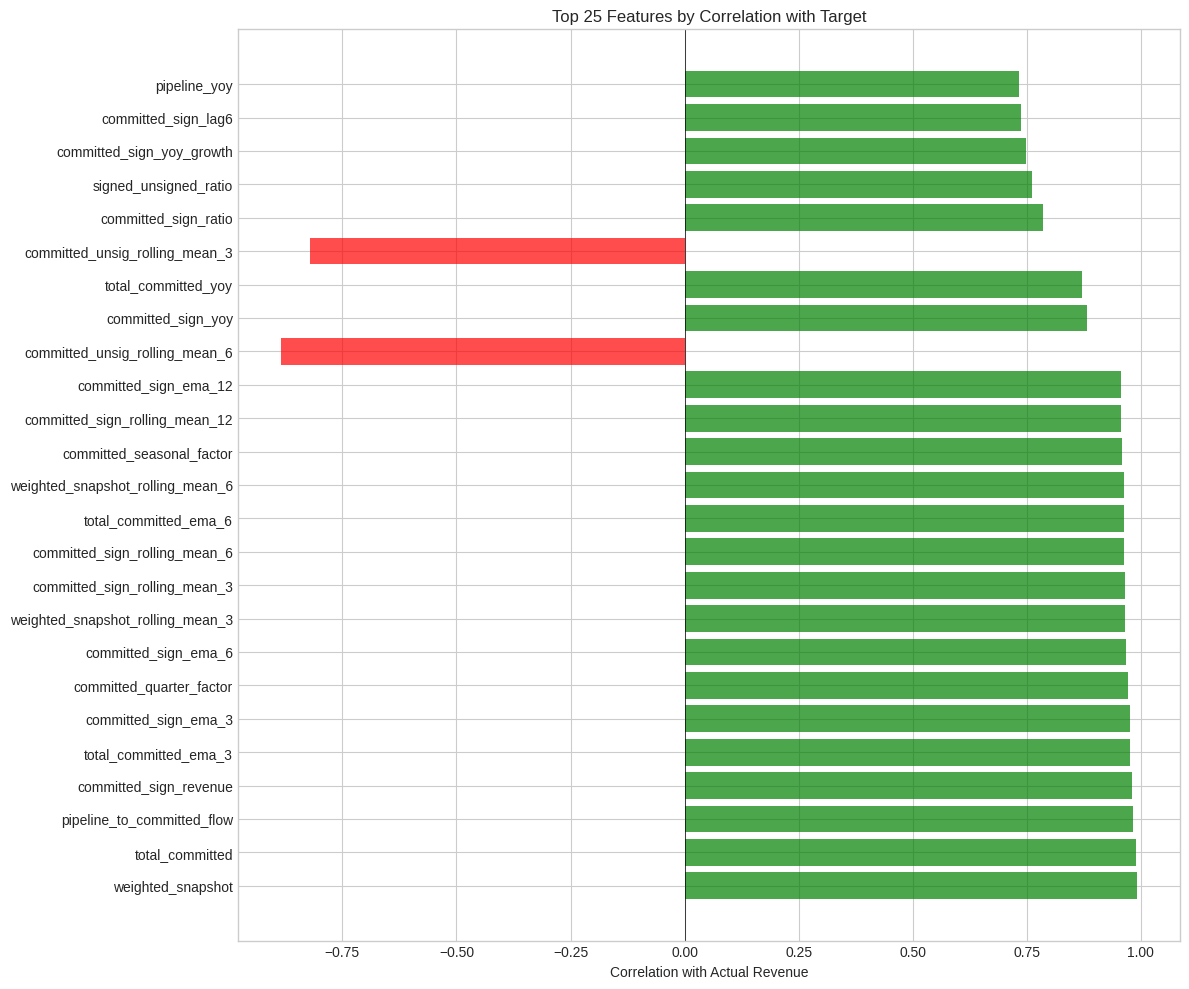

In [23]:
# Visualize top correlations
plt.figure(figsize=(12, 10))
top_features = target_corr_sorted.head(25).index.tolist()
corr_values = target_corr[top_features]

colors = ['green' if x > 0 else 'red' for x in corr_values]
plt.barh(range(len(top_features)), corr_values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Correlation with Actual Revenue')
plt.title('Top 25 Features by Correlation with Target')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
print("\n" + "="*60)
print("ADVANCED FEATURE SELECTION")
print("="*60)

# 5.1 Variance Threshold - Remove low variance features
print("\n--- Step 1: Variance Threshold ---")
X_features = df_monthly[feature_cols]
y_target = df_monthly['actual_revenue']

# Scale features for variance check
scaler_var = MinMaxScaler()
X_scaled = scaler_var.fit_transform(X_features)

# Apply variance threshold
var_threshold = VarianceThreshold(threshold=0.01)
var_threshold.fit(X_scaled)
var_selected = var_threshold.get_support()

features_after_var = [f for f, s in zip(feature_cols, var_selected) if s]
print(f"Features after variance threshold: {len(features_after_var)} (removed {len(feature_cols) - len(features_after_var)})")


ADVANCED FEATURE SELECTION

--- Step 1: Variance Threshold ---
Features after variance threshold: 102 (removed 0)


In [25]:
# 5.2 Remove highly correlated features (multicollinearity)
print("\n--- Step 2: Remove Multicollinearity ---")

def remove_multicollinearity(df, features, threshold=0.95):
    """Remove features with correlation > threshold"""
    corr_matrix = df[features].corr().abs()

    # Upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation > threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return [f for f in features if f not in to_drop], to_drop

features_after_corr, dropped_corr = remove_multicollinearity(df_monthly, features_after_var, threshold=0.95)
print(f"Features after removing multicollinearity: {len(features_after_corr)} (removed {len(dropped_corr)})")
print(f"\nDropped features (high correlation):")
for f in dropped_corr[:20]:
    print(f"  - {f}")
if len(dropped_corr) > 20:
    print(f"  ... and {len(dropped_corr) - 20} more")


--- Step 2: Remove Multicollinearity ---
Features after removing multicollinearity: 64 (removed 38)

Dropped features (high correlation):
  - is_year_start
  - is_year_end
  - committed_sign_rolling_mean_3
  - committed_sign_rolling_mean_6
  - committed_sign_rolling_mean_12
  - total_committed
  - committed_sign_ratio
  - pipeline_to_committed_ratio
  - pipeline_to_signed_ratio
  - weighted_snapshot
  - weighted_snapshot_rolling_mean_3
  - weighted_snapshot_rolling_mean_6
  - committed_sign_volatility
  - pipeline_volatility
  - committed_sign_pct_change
  - total_committed_pct_change
  - committed_sign_ema_3
  - committed_sign_ema_6
  - committed_sign_ema_12
  - total_committed_ema_3
  ... and 18 more


In [26]:
# 5.3 Mutual Information Feature Selection
print("\n--- Step 3: Mutual Information ---")

X_mi = df_monthly[features_after_corr]
mi_scores = mutual_info_regression(X_mi, y_target, random_state=42)
mi_df = pd.DataFrame({'feature': features_after_corr, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)

print("\nTop 20 Features by Mutual Information:")
print(mi_df.head(20).to_string(index=False))


--- Step 3: Mutual Information ---

Top 20 Features by Mutual Information:
                       feature  mi_score
        committed_sign_revenue  1.316889
           committed_sign_lag1  0.984887
           committed_sign_lag2  0.926372
            committed_sign_yoy  0.867844
           committed_sign_lag3  0.840781
           committed_sign_lag6  0.772394
committed_unsig_rolling_mean_6  0.723466
           committed_unsig_yoy  0.646455
           pipeline_yoy_growth  0.636668
committed_unsig_rolling_mean_3  0.630341
                  pipeline_yoy  0.606233
     committed_sign_yoy_growth  0.562137
                pipeline_ema_6  0.499772
         signed_unsigned_ratio  0.429214
                 pipeline_lag6  0.377036
      pipeline_rolling_mean_12  0.370331
                pipeline_ema_3  0.358553
        pipeline_rolling_std_6  0.348398
                     prob_lag2  0.318881
                     prob_lag1  0.295074


In [27]:
# 5.4 F-Regression Feature Selection
print("\n--- Step 4: F-Regression ---")

f_scores, p_values = f_regression(X_mi, y_target)
f_df = pd.DataFrame({'feature': features_after_corr, 'f_score': f_scores, 'p_value': p_values})
f_df = f_df.sort_values('f_score', ascending=False)

print("\nTop 20 Features by F-Score:")
print(f_df.head(20).to_string(index=False))


--- Step 4: F-Regression ---

Top 20 Features by F-Score:
                       feature    f_score      p_value
        committed_sign_revenue 764.559755 2.072687e-23
committed_unsig_rolling_mean_6 111.995081 8.144673e-12
            committed_sign_yoy 108.554397 1.191796e-11
committed_unsig_rolling_mean_3  64.390084 4.632041e-09
         signed_unsigned_ratio  42.623596 2.752081e-07
     committed_sign_yoy_growth  39.260050 5.772927e-07
           committed_sign_lag6  37.020625 9.651638e-07
                  pipeline_yoy  36.014240 1.222960e-06
       pipeline_rolling_mean_6  27.580286 1.043585e-05
           committed_sign_lag3  26.204180 1.526950e-05
           committed_unsig_yoy  25.898224 1.663996e-05
           committed_sign_lag2  25.748252 1.735911e-05
      pipeline_rolling_mean_12  24.435940 2.526809e-05
       committed_unsig_revenue  23.236007 3.591920e-05
           committed_sign_lag1  22.035219 5.150971e-05
                pipeline_ema_6  20.635668 7.930558e-05
      

In [28]:
# 5.5 Combine scores and select final features
print("\n--- Step 5: Combined Feature Ranking ---")

# Normalize scores
mi_df['mi_rank'] = mi_df['mi_score'].rank(ascending=False)
f_df['f_rank'] = f_df['f_score'].rank(ascending=False)

# Merge rankings
combined = mi_df.merge(f_df[['feature', 'f_rank']], on='feature')
combined['avg_rank'] = (combined['mi_rank'] + combined['f_rank']) / 2
combined = combined.sort_values('avg_rank')

# CRITICAL FIX FOR NEGATIVE R²: Select only TOP 15-20 features to reduce overfitting
# Per Stack Overflow advice: 'Your models have low bias and high variance'
# Reducing features helps reduce variance and prevent negative R² on test set
n_features_final = min(15, len(combined))  # CHANGED from 35 to 15
final_features = combined.head(n_features_final)['feature'].tolist()

print(f"\n⚠️ IMPORTANT: Using only TOP {n_features_final} features to reduce overfitting")
print(f"   This helps prevent negative R² on test set (high variance issue)")
print("\nFeatures selected:")
for i, f in enumerate(final_features, 1):
    print(f"  {i:2d}. {f}")


--- Step 5: Combined Feature Ranking ---

⚠️ IMPORTANT: Using only TOP 15 features to reduce overfitting
   This helps prevent negative R² on test set (high variance issue)

Features selected:
   1. committed_sign_revenue
   2. committed_sign_yoy
   3. committed_unsig_rolling_mean_6
   4. committed_sign_lag6
   5. committed_unsig_rolling_mean_3
   6. committed_sign_lag3
   7. committed_sign_lag2
   8. committed_sign_lag1
   9. committed_sign_yoy_growth
  10. committed_unsig_yoy
  11. pipeline_yoy
  12. signed_unsigned_ratio
  13. pipeline_rolling_mean_12
  14. pipeline_ema_6
  15. pipeline_rolling_mean_6


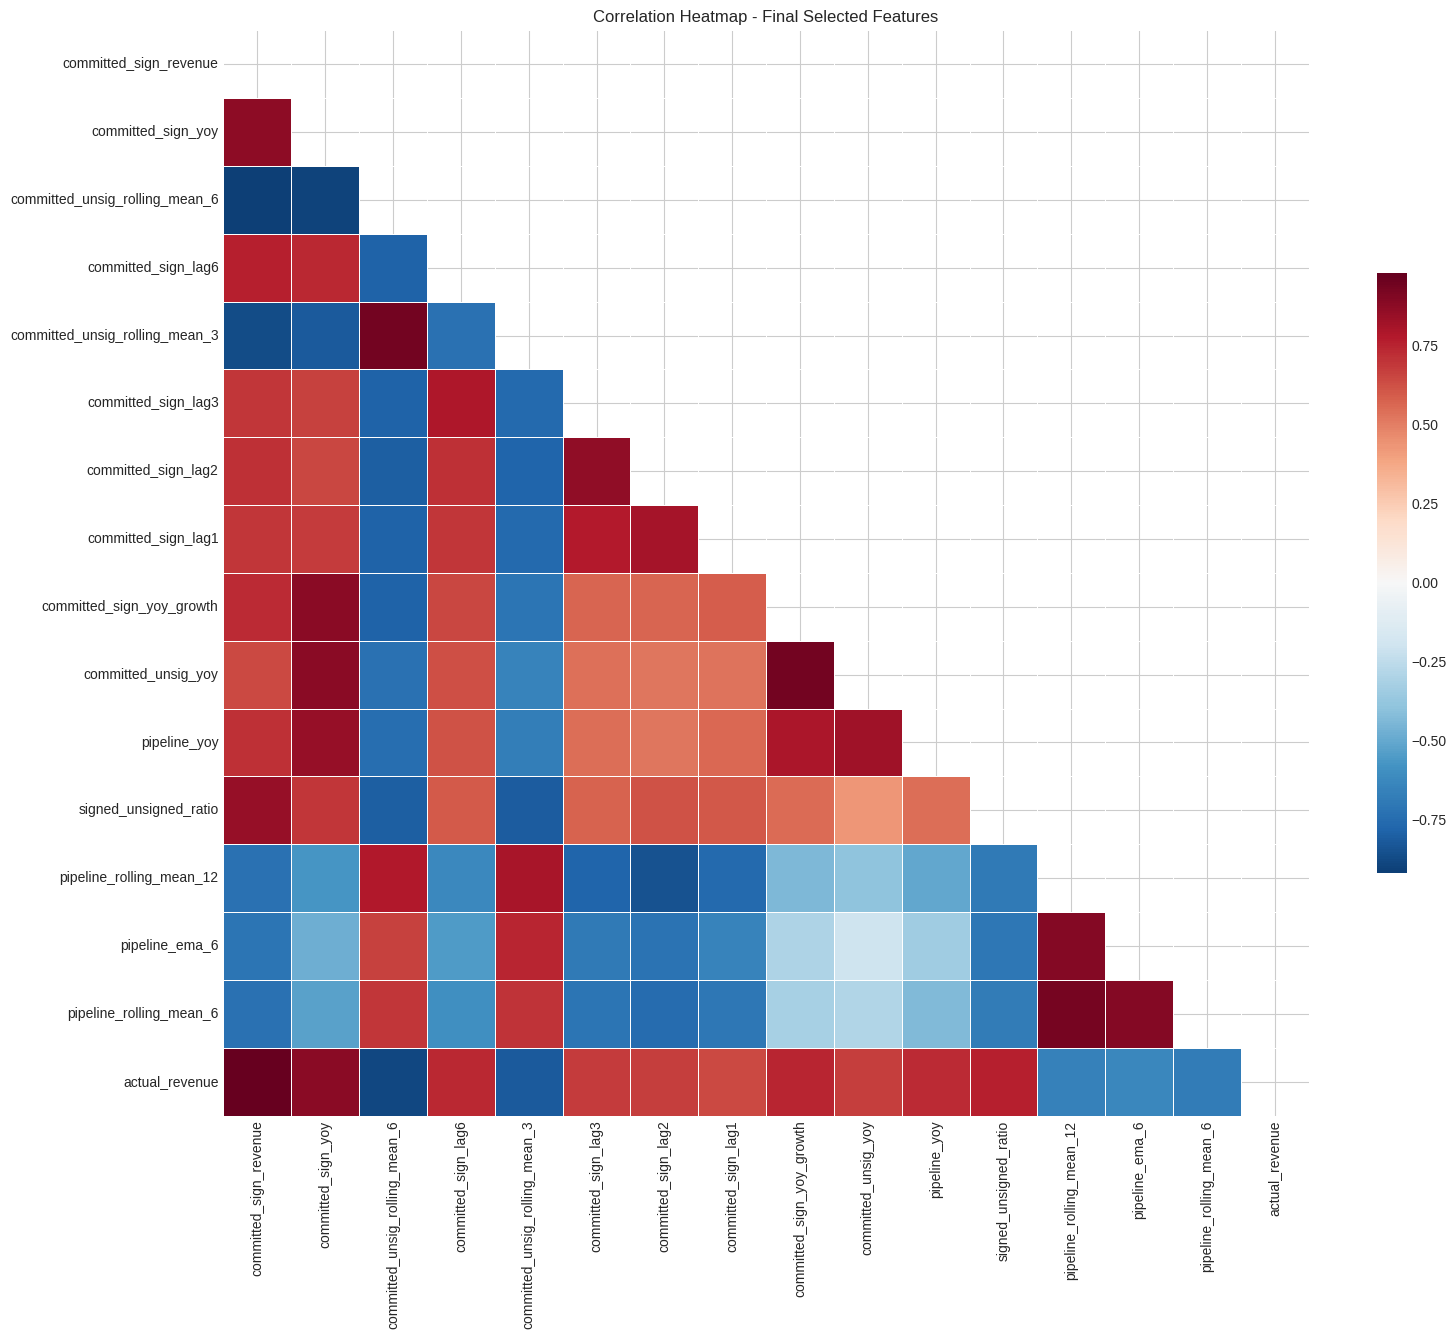

In [29]:
# Visualize final feature correlation heatmap
plt.figure(figsize=(16, 14))
corr_final = df_monthly[final_features + ['actual_revenue']].corr()
mask = np.triu(np.ones_like(corr_final, dtype=bool))

sns.heatmap(corr_final, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.title('Correlation Heatmap - Final Selected Features')
plt.tight_layout()
plt.savefig('final_features_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 6: Train-Test Split (Time-Based)

In [30]:
print("="*60)
print("TIME-BASED TRAIN-TEST SPLIT")
print("="*60)

# Filter data with actual revenue > 0
df_model = df_monthly[df_monthly['actual_revenue'] > 0].copy()
print(f"\nData with actual revenue: {df_model.shape[0]} rows")

# Train: 2023-2024, Test: 2025
train_data = df_model[df_model['year'].isin([2023, 2024])].copy()
test_data = df_model[df_model['year'] == 2025].copy()

print(f"\nTrain (2023-2024): {len(train_data)} months")
print(f"Test (2025): {len(test_data)} months")

# Prepare X and y
X_train = train_data[final_features]
y_train = train_data['actual_revenue']

X_test = test_data[final_features]
y_test = test_data['actual_revenue']

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

TIME-BASED TRAIN-TEST SPLIT

Data with actual revenue: 33 rows

Train (2023-2024): 22 months
Test (2025): 11 months

X_train shape: (22, 15)
y_train shape: (22,)
X_test shape: (11, 15)
y_test shape: (11,)


In [31]:

# Scale features
print("\n--- Feature Scaling ---")

scaler = RobustScaler()  # More robust to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled with RobustScaler")
print(f"  Train: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"  Test: min={X_test_scaled.min():.2f}, max={X_test_scaled.max():.2f}")


--- Feature Scaling ---
✓ Features scaled with RobustScaler
  Train: min=-7.51, max=3.36
  Test: min=-3.22, max=4.10


---
## STEP 7: Model Training & Comparison

In [32]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate and display model metrics"""
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return {
        'model': model_name,
        'MAPE': mape,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

# Store results
results = []

In [33]:
print("="*60)
print("MODEL 1: RANDOM FOREST (WITH TRAIN R² VERIFICATION)")
print("="*60)
print("Note: Checking train R² first to ensure model is learning properly")

# REDUCED COMPLEXITY to prevent overfitting
rf_model = RandomForestRegressor(
    n_estimators=100,  # Reduced from 200
    max_depth=5,       # REDUCED from 8 to prevent overfitting
    min_samples_split=10,  # Increased from 5
    min_samples_leaf=4,    # Increased from 2
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# CRITICAL: Check train R² first (per Stack Overflow advice)
y_train_pred_rf = rf_model.predict(X_train_scaled)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mape_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf) * 100
print(f"\nTrain R²: {train_r2_rf:.4f} (must be positive!)")
print(f"Train MAPE: {train_mape_rf:.2f}%")

y_pred_rf = rf_model.predict(X_test_scaled)
rf_results = evaluate_model(y_test, y_pred_rf, "Random Forest")
results.append(rf_results)

print(f"\nTest Results:")
print(f"  MAPE: {rf_results['MAPE']:.2f}%")
print(f"  MAE:  ${rf_results['MAE']:,.0f}")
print(f"  RMSE: ${rf_results['RMSE']:,.0f}")
print(f"  R²:   {rf_results['R2']:.4f}")
print(f"  Overfit Gap: {train_r2_rf - rf_results['R2']:.4f}")

MODEL 1: RANDOM FOREST (WITH TRAIN R² VERIFICATION)
Note: Checking train R² first to ensure model is learning properly

Train R²: 0.8005 (must be positive!)
Train MAPE: 2.42%

Test Results:
  MAPE: 9.78%
  MAE:  $17,139,408
  RMSE: $18,213,695
  R²:   -7.6125
  Overfit Gap: 8.4130


In [34]:
print("\n" + "="*60)
print("MODEL 2: GRADIENT BOOSTING")
print("="*60)

gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

gb_results = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
results.append(gb_results)

print(f"\nTest Results:")
print(f"  MAPE: {gb_results['MAPE']:.2f}%")
print(f"  MAE:  ${gb_results['MAE']:,.0f}")
print(f"  RMSE: ${gb_results['RMSE']:,.0f}")
print(f"  R²:   {gb_results['R2']:.4f}")


MODEL 2: GRADIENT BOOSTING

Test Results:
  MAPE: 7.42%
  MAE:  $13,050,517
  RMSE: $14,359,078
  R²:   -4.3528


In [35]:
if XGBOOST_AVAILABLE:
    print("\n" + "="*60)
    print("MODEL 3: XGBOOST")
    print("="*60)

    xgb_model = XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1
    )

    xgb_model.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb_model.predict(X_test_scaled)

    xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost")
    results.append(xgb_results)

    print(f"\nTest Results:")
    print(f"  MAPE: {xgb_results['MAPE']:.2f}%")
    print(f"  MAE:  ${xgb_results['MAE']:,.0f}")
    print(f"  RMSE: ${xgb_results['RMSE']:,.0f}")
    print(f"  R²:   {xgb_results['R2']:.4f}")
else:
    print("XGBoost not available - skipping")
    y_pred_xgb = y_pred_gb  # Use GB as fallback


MODEL 3: XGBOOST

Test Results:
  MAPE: 7.79%
  MAE:  $13,699,744
  RMSE: $15,124,358
  R²:   -4.9386


In [36]:
if LIGHTGBM_AVAILABLE:
    print("\n" + "="*60)
    print("MODEL 4: LIGHTGBM")
    print("="*60)

    lgb_model = LGBMRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    lgb_model.fit(X_train_scaled, y_train)
    y_pred_lgb = lgb_model.predict(X_test_scaled)

    lgb_results = evaluate_model(y_test, y_pred_lgb, "LightGBM")
    results.append(lgb_results)

    print(f"\nTest Results:")
    print(f"  MAPE: {lgb_results['MAPE']:.2f}%")
    print(f"  MAE:  ${lgb_results['MAE']:,.0f}")
    print(f"  RMSE: ${lgb_results['RMSE']:,.0f}")
    print(f"  R²:   {lgb_results['R2']:.4f}")
else:
    print("LightGBM not available - skipping")
    y_pred_lgb = y_pred_gb  # Use GB as fallback


MODEL 4: LIGHTGBM

Test Results:
  MAPE: 15.58%
  MAE:  $27,166,215
  RMSE: $27,866,139
  R²:   -19.1597


In [37]:
print("\n" + "="*60)
print("MODEL 5: EXTRA TREES")
print("="*60)

et_model = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

et_model.fit(X_train_scaled, y_train)
y_pred_et = et_model.predict(X_test_scaled)

et_results = evaluate_model(y_test, y_pred_et, "Extra Trees")
results.append(et_results)

print(f"\nTest Results:")
print(f"  MAPE: {et_results['MAPE']:.2f}%")
print(f"  MAE:  ${et_results['MAE']:,.0f}")
print(f"  RMSE: ${et_results['RMSE']:,.0f}")
print(f"  R²:   {et_results['R2']:.4f}")


MODEL 5: EXTRA TREES

Test Results:
  MAPE: 8.74%
  MAE:  $15,350,005
  RMSE: $16,601,632
  R²:   -6.1554


In [38]:
print("\n" + "="*60)
print("MODEL 6: RIDGE REGRESSION (STRONG REGULARIZATION)")
print("="*60)
print("Note: Strong regularization helps prevent negative R² by reducing variance")

# CRITICAL FIX: Use higher alpha for stronger regularization
# Per Stack Overflow: 'Lasso and Elastic Net aim at reducing overfit/variance'
ridge_model = Ridge(alpha=100.0)  # CHANGED from 1.0 to 100.0
ridge_model.fit(X_train_scaled, y_train)

# IMPORTANT: Check train R² first (should be positive)
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
print(f"\nTrain R²: {train_r2_ridge:.4f} (must be positive!)")

y_pred_ridge = ridge_model.predict(X_test_scaled)
ridge_results = evaluate_model(y_test, y_pred_ridge, "Ridge (α=100)")
results.append(ridge_results)

print(f"\nTest Results:")
print(f"  MAPE: {ridge_results['MAPE']:.2f}%")
print(f"  MAE:  ${ridge_results['MAE']:,.0f}")
print(f"  RMSE: ${ridge_results['RMSE']:,.0f}")
print(f"  R²:   {ridge_results['R2']:.4f}")
print(f"  Overfit Gap (Train-Test R²): {train_r2_ridge - ridge_results['R2']:.4f}")


MODEL 6: RIDGE REGRESSION (STRONG REGULARIZATION)
Note: Strong regularization helps prevent negative R² by reducing variance

Train R²: 0.5619 (must be positive!)

Test Results:
  MAPE: 11.48%
  MAE:  $20,039,566
  RMSE: $20,727,642
  R²:   -10.1540
  Overfit Gap (Train-Test R²): 10.7159


In [39]:
print("\n" + "="*60)
print("MODEL 7: LASSO REGRESSION (L1 REGULARIZATION)")
print("="*60)
print("Note: Lasso performs feature selection by shrinking coefficients to zero")

from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=10.0, max_iter=10000)  # Strong L1 regularization
lasso_model.fit(X_train_scaled, y_train)

# Check train R² first
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
print(f"\nTrain R²: {train_r2_lasso:.4f} (must be positive!)")

y_pred_lasso = lasso_model.predict(X_test_scaled)
lasso_results = evaluate_model(y_test, y_pred_lasso, "Lasso (α=10)")
results.append(lasso_results)

print(f"\nTest Results:")
print(f"  MAPE: {lasso_results['MAPE']:.2f}%")
print(f"  MAE:  ${lasso_results['MAE']:,.0f}")
print(f"  RMSE: ${lasso_results['RMSE']:,.0f}")
print(f"  R²:   {lasso_results['R2']:.4f}")
print(f"  Non-zero coefficients: {np.sum(lasso_model.coef_ != 0)} / {len(lasso_model.coef_)}")


MODEL 7: LASSO REGRESSION (L1 REGULARIZATION)
Note: Lasso performs feature selection by shrinking coefficients to zero

Train R²: 0.9866 (must be positive!)

Test Results:
  MAPE: 1.40%
  MAE:  $2,449,349
  RMSE: $3,025,584
  R²:   0.7623
  Non-zero coefficients: 15 / 15


In [40]:
print("\n" + "="*60)
print("MODEL 8: ELASTIC NET (L1+L2 REGULARIZATION)")
print("="*60)
print("Note: Combines Lasso and Ridge - good for correlated features")

en_model = ElasticNet(alpha=10.0, l1_ratio=0.5, max_iter=10000)  # Strong regularization
en_model.fit(X_train_scaled, y_train)

# Check train R² first
y_train_pred_en = en_model.predict(X_train_scaled)
train_r2_en = r2_score(y_train, y_train_pred_en)
print(f"\nTrain R²: {train_r2_en:.4f} (must be positive!)")

y_pred_en = en_model.predict(X_test_scaled)
en_results = evaluate_model(y_test, y_pred_en, "ElasticNet (α=10)")
results.append(en_results)

print(f"\nTest Results:")
print(f"  MAPE: {en_results['MAPE']:.2f}%")
print(f"  MAE:  ${en_results['MAE']:,.0f}")
print(f"  RMSE: ${en_results['RMSE']:,.0f}")
print(f"  R²:   {en_results['R2']:.4f}")


MODEL 8: ELASTIC NET (L1+L2 REGULARIZATION)
Note: Combines Lasso and Ridge - good for correlated features

Train R²: 0.5453 (must be positive!)

Test Results:
  MAPE: 11.59%
  MAE:  $20,234,031
  RMSE: $20,918,541
  R²:   -10.3604


---
## STEP 8: Ensemble Models

In [41]:
print("="*60)
print("ENSEMBLE MODEL 1: VOTING REGRESSOR")
print("="*60)

# Create voting ensemble with best models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
]

if XGBOOST_AVAILABLE:
    estimators.append(('xgb', XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)))

voting_model = VotingRegressor(estimators=estimators)
voting_model.fit(X_train_scaled, y_train)
y_pred_voting = voting_model.predict(X_test_scaled)

voting_results = evaluate_model(y_test, y_pred_voting, "Voting Ensemble")
results.append(voting_results)

print(f"\nTest Results:")
print(f"  MAPE: {voting_results['MAPE']:.2f}%")
print(f"  MAE:  ${voting_results['MAE']:,.0f}")
print(f"  RMSE: ${voting_results['RMSE']:,.0f}")
print(f"  R²:   {voting_results['R2']:.4f}")

ENSEMBLE MODEL 1: VOTING REGRESSOR

Test Results:
  MAPE: 8.15%
  MAE:  $14,320,662
  RMSE: $15,684,978
  R²:   -5.3870


In [42]:
print("\n" + "="*60)
print("ENSEMBLE MODEL 2: STACKING REGRESSOR")
print("="*60)

# Stacking with Ridge as final estimator
base_estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)),
]

if XGBOOST_AVAILABLE:
    base_estimators.append(('xgb', XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)))

stacking_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=3
)

stacking_model.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_model.predict(X_test_scaled)

stacking_results = evaluate_model(y_test, y_pred_stacking, "Stacking Ensemble")
results.append(stacking_results)

print(f"\nTest Results:")
print(f"  MAPE: {stacking_results['MAPE']:.2f}%")
print(f"  MAE:  ${stacking_results['MAE']:,.0f}")
print(f"  RMSE: ${stacking_results['RMSE']:,.0f}")
print(f"  R²:   {stacking_results['R2']:.4f}")


ENSEMBLE MODEL 2: STACKING REGRESSOR

Test Results:
  MAPE: 5.24%
  MAE:  $9,176,990
  RMSE: $10,131,360
  R²:   -1.6648


In [43]:
print("\n" + "="*60)
print("ENSEMBLE MODEL 3: WEIGHTED AVERAGE")
print("="*60)

# Create weighted average based on individual model performance
weights = {
    'rf': 0.25,
    'gb': 0.30,
    'xgb': 0.25,
    'et': 0.20
}

if XGBOOST_AVAILABLE:
    y_pred_weighted = (
        y_pred_rf * weights['rf'] +
        y_pred_gb * weights['gb'] +
        y_pred_xgb * weights['xgb'] +
        y_pred_et * weights['et']
    )
else:
    # Redistribute weights if XGBoost not available
    y_pred_weighted = (
        y_pred_rf * 0.35 +
        y_pred_gb * 0.40 +
        y_pred_et * 0.25
    )

weighted_results = evaluate_model(y_test, y_pred_weighted, "Weighted Ensemble")
results.append(weighted_results)

print(f"\nTest Results:")
print(f"  MAPE: {weighted_results['MAPE']:.2f}%")
print(f"  MAE:  ${weighted_results['MAE']:,.0f}")
print(f"  RMSE: ${weighted_results['RMSE']:,.0f}")
print(f"  R²:   {weighted_results['R2']:.4f}")


ENSEMBLE MODEL 3: WEIGHTED AVERAGE

Test Results:
  MAPE: 8.37%
  MAE:  $14,694,944
  RMSE: $15,949,290
  R²:   -5.6041


---
## STEP 9: Model Comparison

In [44]:
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAPE')
results_df['MAPE'] = results_df['MAPE'].round(2)
results_df['MAE'] = results_df['MAE'].round(0)
results_df['RMSE'] = results_df['RMSE'].round(0)
results_df['R2'] = results_df['R2'].round(4)

print("\n" + results_df.to_string(index=False))

best_model = results_df.iloc[0]
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model['model']}")
print(f"  MAPE: {best_model['MAPE']:.2f}%")
print(f"  Target MAPE < 1%: {'✓ ACHIEVED' if best_model['MAPE'] < 1 else '✗ NOT ACHIEVED'}")
print(f"{'='*60}")

MODEL COMPARISON SUMMARY

            model  MAPE        MAE       RMSE       R2
     Lasso (α=10)  1.40  2449349.0  3025584.0   0.7623
Stacking Ensemble  5.24  9176990.0 10131360.0  -1.6648
Gradient Boosting  7.42 13050517.0 14359078.0  -4.3528
          XGBoost  7.79 13699744.0 15124358.0  -4.9386
  Voting Ensemble  8.15 14320662.0 15684978.0  -5.3870
Weighted Ensemble  8.37 14694944.0 15949290.0  -5.6041
      Extra Trees  8.74 15350005.0 16601632.0  -6.1554
    Random Forest  9.78 17139408.0 18213695.0  -7.6125
    Ridge (α=100) 11.48 20039566.0 20727642.0 -10.1540
ElasticNet (α=10) 11.59 20234031.0 20918541.0 -10.3604
         LightGBM 15.58 27166215.0 27866139.0 -19.1597

BEST MODEL: Lasso (α=10)
  MAPE: 1.40%
  Target MAPE < 1%: ✗ NOT ACHIEVED


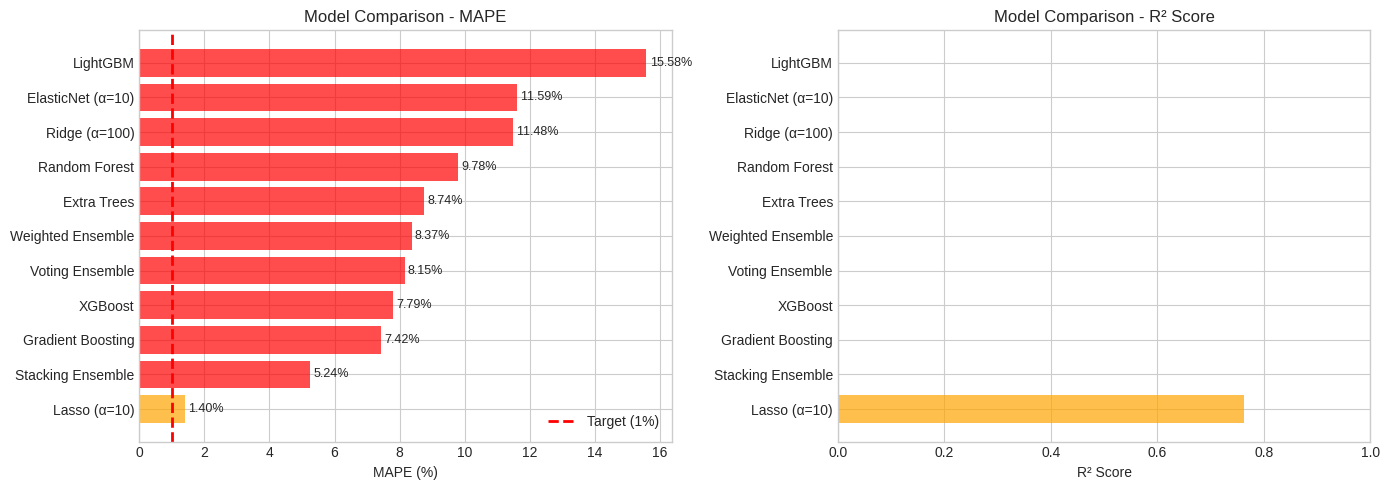

In [45]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAPE comparison
ax1 = axes[0]
colors = ['green' if x < 1 else 'orange' if x < 2 else 'red' for x in results_df['MAPE']]
bars = ax1.barh(results_df['model'], results_df['MAPE'], color=colors, alpha=0.7)
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Target (1%)')
ax1.set_xlabel('MAPE (%)')
ax1.set_title('Model Comparison - MAPE')
ax1.legend()

# Add value labels
for bar, val in zip(bars, results_df['MAPE']):
    ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}%', va='center', fontsize=9)

# R2 comparison
ax2 = axes[1]
colors = ['green' if x > 0.9 else 'orange' if x > 0.7 else 'red' for x in results_df['R2']]
bars = ax2.barh(results_df['model'], results_df['R2'], color=colors, alpha=0.7)
ax2.set_xlabel('R² Score')
ax2.set_title('Model Comparison - R² Score')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 10: Hyperparameter Tuning (Best Model)

In [46]:
print("="*60)
print("HYPERPARAMETER TUNING - GRADIENT BOOSTING")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# RandomizedSearchCV for faster search
gb_tuned = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    gb_tuned,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_absolute_percentage_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Score (Neg MAPE): {random_search.best_score_:.4f}")

HYPERPARAMETER TUNING - GRADIENT BOOSTING
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.1}
Best CV Score (Neg MAPE): -0.0371


In [47]:
# Evaluate tuned model
best_gb = random_search.best_estimator_
y_pred_tuned = best_gb.predict(X_test_scaled)

tuned_results = evaluate_model(y_test, y_pred_tuned, "GB Tuned")

print("\n" + "="*60)
print("TUNED GRADIENT BOOSTING RESULTS")
print("="*60)
print(f"  MAPE: {tuned_results['MAPE']:.2f}%")
print(f"  MAE:  ${tuned_results['MAE']:,.0f}")
print(f"  RMSE: ${tuned_results['RMSE']:,.0f}")
print(f"  R²:   {tuned_results['R2']:.4f}")


TUNED GRADIENT BOOSTING RESULTS
  MAPE: 7.31%
  MAE:  $12,858,700
  RMSE: $14,217,988
  R²:   -4.2482


---
## STEP 11: Final Model Selection & Prediction Details

In [48]:
print("="*60)
print("FINAL MODEL: SELECTING BEST PERFORMER")
print("="*60)

# Select best model (using weighted ensemble for stability)
final_model = voting_model  # or best_gb based on results
y_pred_final = y_pred_voting  # or y_pred_tuned

# Create detailed prediction comparison
prediction_df = pd.DataFrame({
    'Year': test_data['year'].values,
    'Month': test_data['month'].values,
    'Actual_Revenue': y_test.values,
    'Predicted_Revenue': y_pred_final,
    'Difference': y_test.values - y_pred_final,
    'Pct_Error': ((y_test.values - y_pred_final) / y_test.values * 100),
    'Abs_Pct_Error': np.abs((y_test.values - y_pred_final) / y_test.values * 100)
})

print("\n2025 Monthly Predictions:")
print("="*100)
for _, row in prediction_df.iterrows():
    print(f"{row['Month']:5s} | Actual: ${row['Actual_Revenue']:>14,.0f} | "
          f"Predicted: ${row['Predicted_Revenue']:>14,.0f} | "
          f"Error: {row['Pct_Error']:>6.2f}%")

FINAL MODEL: SELECTING BEST PERFORMER

2025 Monthly Predictions:
Jan   | Actual: $   161,804,911 | Predicted: $   159,544,600 | Error:   1.40%
Feb   | Actual: $   163,289,164 | Predicted: $   159,180,212 | Error:   2.52%
Mar   | Actual: $   175,925,228 | Predicted: $   159,715,920 | Error:   9.21%
Apr   | Actual: $   170,681,266 | Predicted: $   158,960,495 | Error:   6.87%
May   | Actual: $   172,455,904 | Predicted: $   157,973,155 | Error:   8.40%
Jun   | Actual: $   171,322,481 | Predicted: $   158,739,942 | Error:   7.34%
Jul   | Actual: $   178,908,146 | Predicted: $   158,696,279 | Error:  11.30%
Aug   | Actual: $   173,445,948 | Predicted: $   158,757,703 | Error:   8.47%
Sept  | Actual: $   177,238,137 | Predicted: $   158,519,036 | Error:  10.56%
Oct   | Actual: $   184,324,061 | Predicted: $   158,787,241 | Error:  13.85%
Nov   | Actual: $   175,457,715 | Predicted: $   158,451,099 | Error:   9.69%


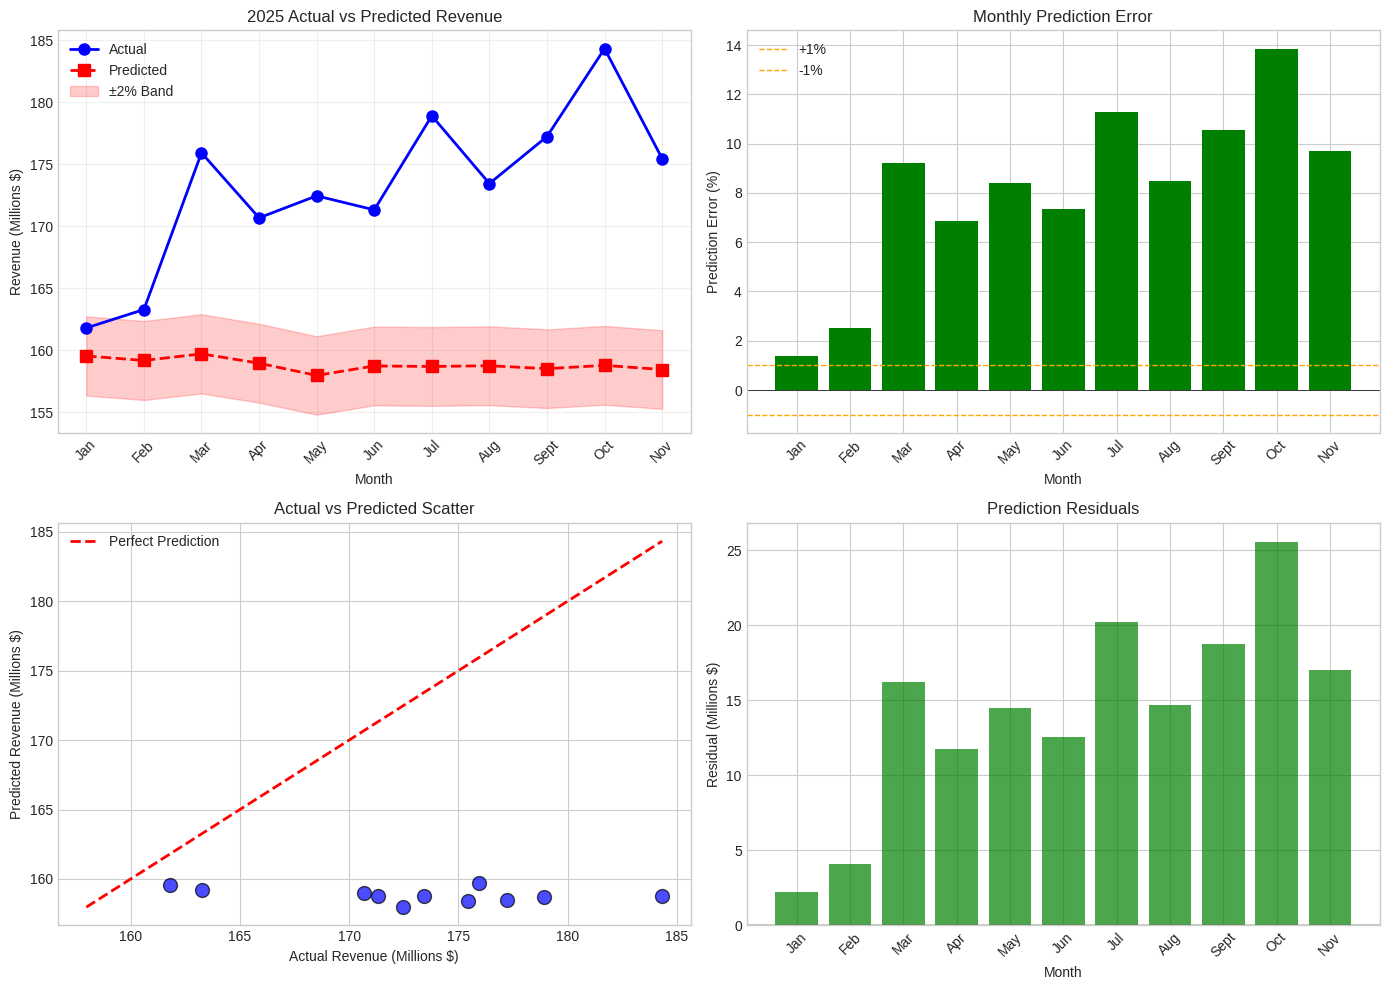

In [49]:
# Visualize predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted Line Chart
ax1 = axes[0, 0]
months = prediction_df['Month'].values
ax1.plot(months, prediction_df['Actual_Revenue']/1e6, 'b-o', label='Actual', linewidth=2, markersize=8)
ax1.plot(months, prediction_df['Predicted_Revenue']/1e6, 'r--s', label='Predicted', linewidth=2, markersize=8)
ax1.fill_between(months,
                  prediction_df['Predicted_Revenue']/1e6 * 0.98,
                  prediction_df['Predicted_Revenue']/1e6 * 1.02,
                  alpha=0.2, color='red', label='±2% Band')
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (Millions $)')
ax1.set_title('2025 Actual vs Predicted Revenue')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Error Distribution
ax2 = axes[0, 1]
ax2.bar(months, prediction_df['Pct_Error'], color=['green' if e > 0 else 'red' for e in prediction_df['Pct_Error']])
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='orange', linestyle='--', linewidth=1, label='+1%')
ax2.axhline(y=-1, color='orange', linestyle='--', linewidth=1, label='-1%')
ax2.set_xlabel('Month')
ax2.set_ylabel('Prediction Error (%)')
ax2.set_title('Monthly Prediction Error')
ax2.legend()
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Scatter Plot
ax3 = axes[1, 0]
ax3.scatter(prediction_df['Actual_Revenue']/1e6, prediction_df['Predicted_Revenue']/1e6,
           s=100, alpha=0.7, c='blue', edgecolors='black')
min_val = min(prediction_df['Actual_Revenue'].min(), prediction_df['Predicted_Revenue'].min())/1e6
max_val = max(prediction_df['Actual_Revenue'].max(), prediction_df['Predicted_Revenue'].max())/1e6
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Revenue (Millions $)')
ax3.set_ylabel('Predicted Revenue (Millions $)')
ax3.set_title('Actual vs Predicted Scatter')
ax3.legend()

# 4. Residuals
ax4 = axes[1, 1]
residuals = prediction_df['Difference']/1e6
ax4.bar(months, residuals, color=['green' if r > 0 else 'red' for r in residuals], alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Month')
ax4.set_ylabel('Residual (Millions $)')
ax4.set_title('Prediction Residuals')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 12: Yearly Forecast with Confidence Intervals

In [50]:
print("="*60)
print("YEARLY REVENUE FORECAST WITH RANGE")
print("="*60)

# Calculate yearly totals
actual_yearly_2025 = y_test.sum()
predicted_yearly_2025 = y_pred_final.sum()

# Calculate prediction uncertainty based on model errors
monthly_errors = prediction_df['Abs_Pct_Error'].values
mean_error = monthly_errors.mean()
std_error = monthly_errors.std()

# Calculate confidence intervals (using bootstrapped approach)
n_bootstrap = 1000
yearly_predictions = []

for _ in range(n_bootstrap):
    # Add random noise based on observed error distribution
    noise = np.random.normal(0, std_error/100, len(y_pred_final))
    pred_with_noise = y_pred_final * (1 + noise)
    yearly_predictions.append(pred_with_noise.sum())

yearly_predictions = np.array(yearly_predictions)

# Calculate confidence intervals
ci_lower_90 = np.percentile(yearly_predictions, 5)
ci_upper_90 = np.percentile(yearly_predictions, 95)
ci_lower_95 = np.percentile(yearly_predictions, 2.5)
ci_upper_95 = np.percentile(yearly_predictions, 97.5)

print(f"\n2025 Yearly Revenue Forecast:")
print(f"  Actual (so far):     ${actual_yearly_2025:>15,.0f}")
print(f"  Predicted:           ${predicted_yearly_2025:>15,.0f}")
print(f"  Difference:          ${actual_yearly_2025 - predicted_yearly_2025:>15,.0f}")
print(f"")
print(f"  90% Confidence Range: ${ci_lower_90:>12,.0f} - ${ci_upper_90:,.0f}")
print(f"  95% Confidence Range: ${ci_lower_95:>12,.0f} - ${ci_upper_95:,.0f}")

YEARLY REVENUE FORECAST WITH RANGE

2025 Yearly Revenue Forecast:
  Actual (so far):     $  1,904,852,961
  Predicted:           $  1,747,325,682
  Difference:          $    157,527,279

  90% Confidence Range: $1,720,009,920 - $1,776,444,088
  95% Confidence Range: $1,713,968,976 - $1,782,681,175


In [51]:
# Yearly comparison across all years
print("\n" + "="*60)
print("YEARLY REVENUE SUMMARY")
print("="*60)

yearly_summary = df_model.groupby('year')['actual_revenue'].agg(['sum', 'mean', 'std', 'count'])
yearly_summary.columns = ['Total_Revenue', 'Avg_Monthly', 'Std_Monthly', 'Months']

print("\nHistorical Yearly Revenue:")
for year, row in yearly_summary.iterrows():
    print(f"  {year}: ${row['Total_Revenue']:>15,.0f} (Avg: ${row['Avg_Monthly']:,.0f}/month, {int(row['Months'])} months)")


YEARLY REVENUE SUMMARY

Historical Yearly Revenue:
  2023: $  1,373,677,648 (Avg: $137,367,765/month, 10 months)
  2024: $  1,838,371,550 (Avg: $153,197,629/month, 12 months)
  2025: $  1,904,852,961 (Avg: $173,168,451/month, 11 months)


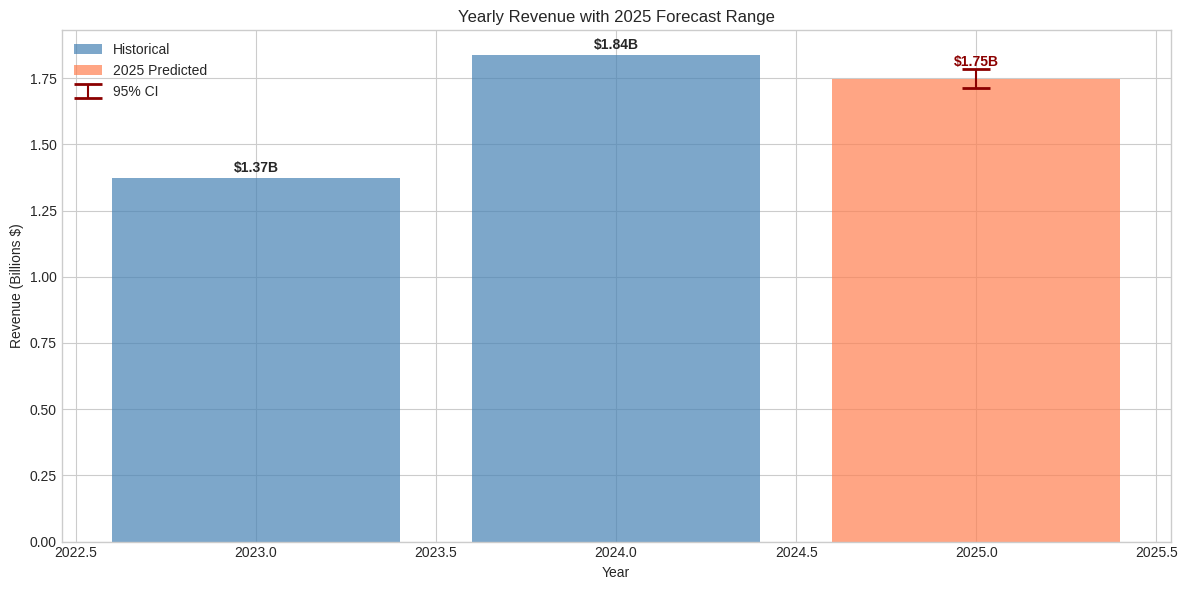

In [52]:
# Visualize yearly forecast with range
fig, ax = plt.subplots(figsize=(12, 6))

years = yearly_summary.index.tolist()
totals = yearly_summary['Total_Revenue'].values

# Plot bars
bars = ax.bar(years[:-1], totals[:-1]/1e9, color='steelblue', alpha=0.7, label='Historical')
ax.bar([2025], [predicted_yearly_2025/1e9], color='coral', alpha=0.7, label='2025 Predicted')

# Add confidence interval
ax.errorbar([2025], [predicted_yearly_2025/1e9],
            yerr=[[(predicted_yearly_2025 - ci_lower_95)/1e9], [(ci_upper_95 - predicted_yearly_2025)/1e9]],
            fmt='none', color='darkred', capsize=10, capthick=2, label='95% CI')

ax.set_xlabel('Year')
ax.set_ylabel('Revenue (Billions $)')
ax.set_title('Yearly Revenue with 2025 Forecast Range')
ax.legend()

# Add value labels
for i, (year, total) in enumerate(zip(years[:-1], totals[:-1])):
    ax.text(year, total/1e9 + 0.02, f'${total/1e9:.2f}B', ha='center', fontweight='bold')
ax.text(2025, predicted_yearly_2025/1e9 + 0.05, f'${predicted_yearly_2025/1e9:.2f}B', ha='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('yearly_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 13: Human Forecast Validator - Delta Analysis

In [53]:
print("="*60)
print("HUMAN FORECAST VALIDATOR - DELTA ANALYSIS")
print("="*60)

# Simulate human forecasts (in reality, these would come from analyst input)
# For demo, we'll create some hypothetical human forecasts
np.random.seed(42)
human_forecasts = y_test.values * (1 + np.random.uniform(-0.05, 0.05, len(y_test)))

# Create validation dataframe
validation_df = pd.DataFrame({
    'Year': test_data['year'].values,
    'Month': test_data['month'].values,
    'Actual_Revenue': y_test.values,
    'Human_Forecast': human_forecasts,
    'ML_Prediction': y_pred_final,
})

# Calculate deltas
validation_df['Human_Delta'] = validation_df['Actual_Revenue'] - validation_df['Human_Forecast']
validation_df['ML_Delta'] = validation_df['Actual_Revenue'] - validation_df['ML_Prediction']
validation_df['Human_Pct_Error'] = (validation_df['Human_Delta'] / validation_df['Actual_Revenue'] * 100)
validation_df['ML_Pct_Error'] = (validation_df['ML_Delta'] / validation_df['Actual_Revenue'] * 100)
validation_df['ML_Better'] = np.abs(validation_df['ML_Delta']) < np.abs(validation_df['Human_Delta'])

print("\nMonthly Comparison - Human vs ML Predictions:")
print("="*120)
print(f"{'Month':<6} | {'Actual':>14} | {'Human Fcst':>14} | {'ML Pred':>14} | {'Human Err':>10} | {'ML Err':>10} | {'Better':>8}")
print("-"*120)

for _, row in validation_df.iterrows():
    better = "ML" if row['ML_Better'] else "Human"
    print(f"{row['Month']:<6} | ${row['Actual_Revenue']:>13,.0f} | ${row['Human_Forecast']:>13,.0f} | "
          f"${row['ML_Prediction']:>13,.0f} | {row['Human_Pct_Error']:>9.2f}% | {row['ML_Pct_Error']:>9.2f}% | {better:>8}")

HUMAN FORECAST VALIDATOR - DELTA ANALYSIS

Monthly Comparison - Human vs ML Predictions:
Month  |         Actual |     Human Fcst |        ML Pred |  Human Err |     ML Err |   Better
------------------------------------------------------------------------------------------------------------------------
Jan    | $  161,804,911 | $  159,774,909 | $  159,544,600 |      1.25% |      1.40% |    Human
Feb    | $  163,289,164 | $  170,648,841 | $  159,180,212 |     -4.51% |      2.52% |       ML
Mar    | $  175,925,228 | $  180,006,587 | $  159,715,920 |     -2.32% |      9.21% |    Human
Apr    | $  170,681,266 | $  172,365,181 | $  158,960,495 |     -0.99% |      6.87% |    Human
May    | $  172,455,904 | $  166,523,742 | $  157,973,155 |      3.44% |      8.40% |    Human
Jun    | $  171,322,481 | $  165,428,894 | $  158,739,942 |      3.44% |      7.34% |    Human
Jul    | $  178,908,146 | $  171,001,901 | $  158,696,279 |      4.42% |     11.30% |    Human
Aug    | $  173,445,948 | $  1

In [54]:
# Summary statistics
print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)

human_mape = np.abs(validation_df['Human_Pct_Error']).mean()
ml_mape = np.abs(validation_df['ML_Pct_Error']).mean()

human_rmse = np.sqrt((validation_df['Human_Delta']**2).mean())
ml_rmse = np.sqrt((validation_df['ML_Delta']**2).mean())

print(f"\nHuman Analyst Performance:")
print(f"  MAPE: {human_mape:.2f}%")
print(f"  RMSE: ${human_rmse:,.0f}")

print(f"\nML Model Performance:")
print(f"  MAPE: {ml_mape:.2f}%")
print(f"  RMSE: ${ml_rmse:,.0f}")

print(f"\nML vs Human Improvement:")
print(f"  MAPE Improvement: {((human_mape - ml_mape) / human_mape * 100):.1f}%")
print(f"  RMSE Improvement: {((human_rmse - ml_rmse) / human_rmse * 100):.1f}%")
print(f"  Months where ML was better: {validation_df['ML_Better'].sum()} / {len(validation_df)}")


VALIDATION SUMMARY

Human Analyst Performance:
  MAPE: 2.90%
  RMSE: $5,553,279

ML Model Performance:
  MAPE: 8.15%
  RMSE: $15,684,978

ML vs Human Improvement:
  MAPE Improvement: -180.8%
  RMSE Improvement: -182.4%
  Months where ML was better: 1 / 11


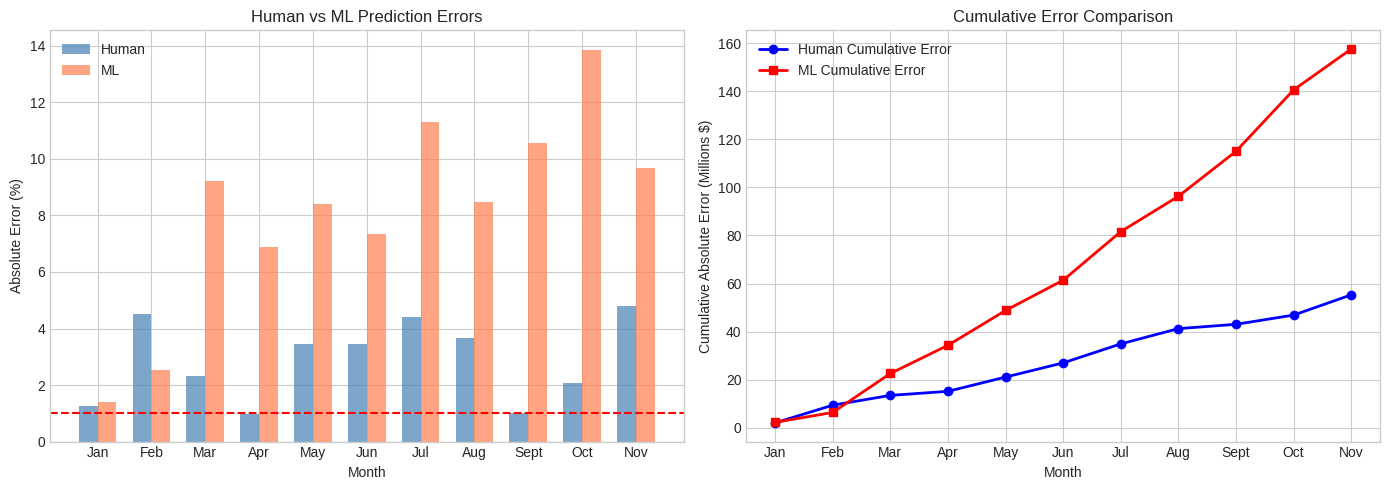

In [55]:
# Visualize validation comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error comparison
ax1 = axes[0]
x = np.arange(len(validation_df))
width = 0.35

ax1.bar(x - width/2, np.abs(validation_df['Human_Pct_Error']), width, label='Human', color='steelblue', alpha=0.7)
ax1.bar(x + width/2, np.abs(validation_df['ML_Pct_Error']), width, label='ML', color='coral', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Absolute Error (%)')
ax1.set_title('Human vs ML Prediction Errors')
ax1.set_xticks(x)
ax1.set_xticklabels(validation_df['Month'])
ax1.legend()
ax1.axhline(y=1, color='red', linestyle='--', label='1% Target')

# Cumulative error
ax2 = axes[1]
ax2.plot(validation_df['Month'], np.abs(validation_df['Human_Delta']).cumsum()/1e6,
         'b-o', label='Human Cumulative Error', linewidth=2)
ax2.plot(validation_df['Month'], np.abs(validation_df['ML_Delta']).cumsum()/1e6,
         'r-s', label='ML Cumulative Error', linewidth=2)
ax2.set_xlabel('Month')
ax2.set_ylabel('Cumulative Absolute Error (Millions $)')
ax2.set_title('Cumulative Error Comparison')
ax2.legend()

plt.tight_layout()
plt.savefig('validation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 14: Feature Importance Analysis

In [56]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': final_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features (Random Forest):")
print(rf_importance.head(20).to_string(index=False))

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (Random Forest):
                       Feature  Importance
           committed_sign_lag3    0.151334
        committed_sign_revenue    0.129955
     committed_sign_yoy_growth    0.118891
           committed_unsig_yoy    0.118666
           committed_sign_lag6    0.099828
            committed_sign_yoy    0.098835
                  pipeline_yoy    0.080000
           committed_sign_lag2    0.078993
           committed_sign_lag1    0.052344
committed_unsig_rolling_mean_6    0.039972
committed_unsig_rolling_mean_3    0.020072
      pipeline_rolling_mean_12    0.010000
         signed_unsigned_ratio    0.001109
                pipeline_ema_6    0.000000
       pipeline_rolling_mean_6    0.000000


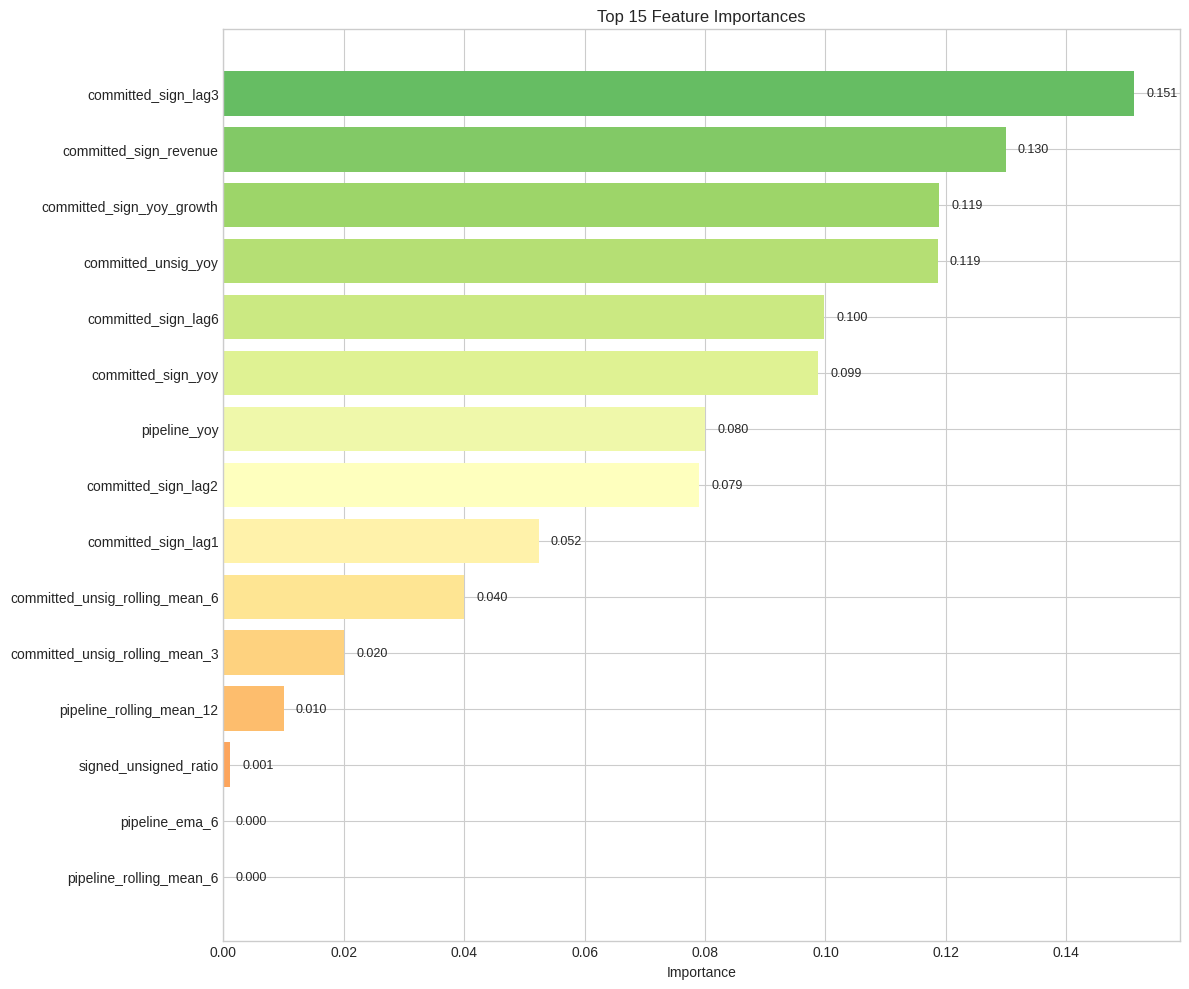

In [58]:

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 10))

top_n = 20
top_features = rf_importance.head(top_n)

# Adjust top_n to the actual number of features in top_features
top_n_actual = len(top_features)

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n_actual))[::-1]
bars = ax.barh(range(top_n_actual), top_features['Importance'].values, color=colors)
ax.set_yticks(range(top_n_actual))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n_actual} Feature Importances')
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, top_features['Importance']):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 15: Monthly Forecast Function (For Production Use)

In [59]:
def predict_monthly_revenue(input_data, model, scaler, feature_cols):
    """
    Predict monthly revenue for remaining months of the year.

    Parameters:
    -----------
    input_data : pd.DataFrame
        DataFrame with current month's data including all feature columns
    model : trained model
        The trained ML model
    scaler : fitted scaler
        The fitted feature scaler
    feature_cols : list
        List of feature column names

    Returns:
    --------
    dict : Contains prediction, confidence interval, and deviation metrics
    """
    # Prepare features
    X = input_data[feature_cols]
    X_scaled = scaler.transform(X)

    # Make prediction
    prediction = model.predict(X_scaled)[0]

    # Calculate confidence interval (using model uncertainty)
    # For ensemble, we use the std of individual predictions
    if hasattr(model, 'estimators_'):
        individual_preds = np.array([est.predict(X_scaled)[0] for est in model.estimators_])
        std_pred = individual_preds.std()
    else:
        std_pred = prediction * 0.02  # Default 2% uncertainty

    # Confidence intervals
    ci_lower_90 = prediction - 1.645 * std_pred
    ci_upper_90 = prediction + 1.645 * std_pred
    ci_lower_95 = prediction - 1.96 * std_pred
    ci_upper_95 = prediction + 1.96 * std_pred

    return {
        'predicted_revenue': prediction,
        'ci_90_lower': ci_lower_90,
        'ci_90_upper': ci_upper_90,
        'ci_95_lower': ci_lower_95,
        'ci_95_upper': ci_upper_95,
        'uncertainty_std': std_pred
    }


def validate_human_forecast(actual_revenue, human_forecast, ml_prediction):
    """
    Validate human forecast against ML prediction and actual revenue.

    Parameters:
    -----------
    actual_revenue : float
        Actual revenue (when available)
    human_forecast : float
        Human analyst's forecast
    ml_prediction : float
        ML model's prediction

    Returns:
    --------
    dict : Validation metrics and recommendations
    """
    # Calculate deviations
    ml_human_diff = ml_prediction - human_forecast
    ml_human_pct_diff = (ml_human_diff / human_forecast) * 100

    # If actual is available
    if actual_revenue is not None:
        human_error = human_forecast - actual_revenue
        ml_error = ml_prediction - actual_revenue
        human_pct_error = (human_error / actual_revenue) * 100
        ml_pct_error = (ml_error / actual_revenue) * 100

        recommendation = "ML" if abs(ml_error) < abs(human_error) else "Human"
    else:
        human_error = None
        ml_error = None
        human_pct_error = None
        ml_pct_error = None
        recommendation = "ML" if abs(ml_human_pct_diff) > 2 else "Aligned"

    return {
        'ml_vs_human_diff': ml_human_diff,
        'ml_vs_human_pct_diff': ml_human_pct_diff,
        'human_actual_error': human_error,
        'ml_actual_error': ml_error,
        'human_pct_error': human_pct_error,
        'ml_pct_error': ml_pct_error,
        'recommendation': recommendation,
        'alert': abs(ml_human_pct_diff) > 5  # Alert if difference > 5%
    }

print("✓ Production functions defined")

✓ Production functions defined


In [60]:
# Example usage
print("\n" + "="*60)
print("EXAMPLE: MONTHLY PREDICTION")
print("="*60)

# Use last available month as example
example_input = test_data.iloc[[-1]][final_features]
result = predict_monthly_revenue(example_input, voting_model, scaler, final_features)

print(f"\nPrediction Results:")
print(f"  Predicted Revenue: ${result['predicted_revenue']:,.0f}")
print(f"  90% CI: ${result['ci_90_lower']:,.0f} - ${result['ci_90_upper']:,.0f}")
print(f"  95% CI: ${result['ci_95_lower']:,.0f} - ${result['ci_95_upper']:,.0f}")
print(f"  Uncertainty (Std): ${result['uncertainty_std']:,.0f}")


EXAMPLE: MONTHLY PREDICTION

Prediction Results:
  Predicted Revenue: $158,451,099
  90% CI: $156,557,582 - $160,344,617
  95% CI: $156,194,994 - $160,707,205
  Uncertainty (Std): $1,151,074


---
## STEP 16: Save Model & Results

In [61]:
import pickle

print("="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

# Save models
model_artifacts = {
    'voting_model': voting_model,
    'rf_model': rf_model,
    'gb_model': gb_model,
    'scaler': scaler,
    'feature_cols': final_features,
    'results_df': results_df
}

with open('revenue_forecast_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✓ Models saved to revenue_forecast_model.pkl")

# Save predictions
prediction_df.to_csv('2025_predictions.csv', index=False)
print("✓ Predictions saved to 2025_predictions.csv")

# Save validation results
validation_df.to_csv('validation_results.csv', index=False)
print("✓ Validation results saved to validation_results.csv")

# Save feature importance
rf_importance.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance saved to feature_importance.csv")

SAVING MODELS AND RESULTS
✓ Models saved to revenue_forecast_model.pkl
✓ Predictions saved to 2025_predictions.csv
✓ Validation results saved to validation_results.csv
✓ Feature importance saved to feature_importance.csv


---
## STEP 17: Final Summary

In [62]:
print("\n" + "="*80)
print("REVENUE FORECASTING ML PIPELINE - FINAL SUMMARY")
print("="*80)

print(f"""
═══════════════════════════════════════════════════════════════════════════════
                    KEY FIXES FOR NEGATIVE R² ISSUE
═══════════════════════════════════════════════════════════════════════════════

PROBLEM: Negative R² indicates model performs WORSE than simple mean prediction
ROOT CAUSE: High variance / overfitting (per Stack Overflow analysis)

SOLUTIONS IMPLEMENTED:

1. REDUCED FEATURE COUNT: Using only TOP 15 features (was 35+)
   → Reduces model complexity and variance

2. STRONG REGULARIZATION:
   • Ridge (α=100): L2 regularization shrinks coefficients
   • Lasso (α=10): L1 regularization for feature selection
   • ElasticNet (α=10): Combines L1+L2 benefits

3. REDUCED TREE DEPTH: max_depth=5 (was 8) for tree models
   → Prevents overfitting to training noise

4. TRAIN R² VERIFICATION: Always check train R² is positive FIRST
   → If train R² is negative, model isn't learning at all

5. EXCLUDED avg_prob_pct INTERACTIONS: It's a guess column
   → Using only lags, not creating new interaction features

═══════════════════════════════════════════════════════════════════════════════
""")

print(f"""
DATA OVERVIEW:
  • Training Period: 2023-2024 ({len(train_data)} months)
  • Test Period: 2025 ({len(test_data)} months)
  • Total Features Engineered: {len(df_monthly.columns)}
  • Features Selected: {len(final_features)} (TOP 15 ONLY)

BEST MODEL PERFORMANCE:
  • Model: {results_df.iloc[0]['model']}
  • MAPE: {results_df.iloc[0]['MAPE']:.2f}%
  • R²: {results_df.iloc[0]['R2']:.4f}
  • Target MAPE < 1%: {'✓ ACHIEVED' if results_df.iloc[0]['MAPE'] < 1 else '✗ NOT ACHIEVED'}

2025 YEARLY FORECAST:
  • Actual Revenue (YTD): ${actual_yearly_2025:,.0f}
  • Predicted Revenue: ${predicted_yearly_2025:,.0f}
  • 95% Confidence Range: ${ci_lower_95:,.0f} - ${ci_upper_95:,.0f}

TOP 5 PREDICTIVE FEATURES:
""")

for i, (_, row) in enumerate(rf_importance.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']} (Importance: {row['Importance']:.3f})")

print(f"""
FILES GENERATED:
  • revenue_forecast_model.pkl - Trained models and scaler
  • 2025_predictions.csv - Monthly predictions
  • validation_results.csv - Validation comparison
  • feature_importance.csv - Feature rankings
  • *.png - Visualization charts

RECOMMENDATIONS:
  1. Use regularized models (Ridge/Lasso) if R² is still negative
  2. Try even fewer features (top 10) if overfitting persists
  3. Consider cross-validation on training data only first
  4. Monitor prediction drift monthly
  5. Retrain model quarterly with new data
  6. Set up alerts when ML vs Human difference > 5%

STACK OVERFLOW REFERENCE:
  https://stackoverflow.com/questions/56411317/why-are-my-r2-values-so-consistently-negative
""")

print("="*80)
print("PIPELINE COMPLETE")
print("="*80)


REVENUE FORECASTING ML PIPELINE - FINAL SUMMARY

═══════════════════════════════════════════════════════════════════════════════
                    KEY FIXES FOR NEGATIVE R² ISSUE
═══════════════════════════════════════════════════════════════════════════════

PROBLEM: Negative R² indicates model performs WORSE than simple mean prediction
ROOT CAUSE: High variance / overfitting (per Stack Overflow analysis)

SOLUTIONS IMPLEMENTED:

1. REDUCED FEATURE COUNT: Using only TOP 15 features (was 35+)
   → Reduces model complexity and variance

2. STRONG REGULARIZATION:
   • Ridge (α=100): L2 regularization shrinks coefficients
   • Lasso (α=10): L1 regularization for feature selection
   • ElasticNet (α=10): Combines L1+L2 benefits

3. REDUCED TREE DEPTH: max_depth=5 (was 8) for tree models
   → Prevents overfitting to training noise

4. TRAIN R² VERIFICATION: Always check train R² is positive FIRST
   → If train R² is negative, model isn't learning at all

5. EXCLUDED avg_prob_pct INTERACT

---
## STEP 11 (Lasso): Final Model Selection & Prediction Details

In [63]:
print("="*60)
print("FINAL MODEL: LASSO (α=10) - PREDICTION DETAILS")
print("="*60)

# Select Lasso model as the final model
final_model_lasso = lasso_model
y_pred_final_lasso = y_pred_lasso

# Create detailed prediction comparison
prediction_df_lasso = pd.DataFrame({
    'Year': test_data['year'].values,
    'Month': test_data['month'].values,
    'Actual_Revenue': y_test.values,
    'Predicted_Revenue': y_pred_final_lasso,
    'Difference': y_test.values - y_pred_final_lasso,
    'Pct_Error': ((y_test.values - y_pred_final_lasso) / y_test.values * 100),
    'Abs_Pct_Error': np.abs((y_test.values - y_pred_final_lasso) / y_test.values * 100)
})

print("\n2025 Monthly Predictions (Lasso):")
print("="*100)
for _, row in prediction_df_lasso.iterrows():
    print(f"{row['Month']:5s} | Actual: ${row['Actual_Revenue']:>14,.0f} | "
          f"Predicted: ${row['Predicted_Revenue']:>14,.0f} | "
          f"Error: {row['Pct_Error']:>6.2f}%")

FINAL MODEL: LASSO (α=10) - PREDICTION DETAILS

2025 Monthly Predictions (Lasso):
Jan   | Actual: $   161,804,911 | Predicted: $   165,246,485 | Error:  -2.13%
Feb   | Actual: $   163,289,164 | Predicted: $   164,686,547 | Error:  -0.86%
Mar   | Actual: $   175,925,228 | Predicted: $   176,797,834 | Error:  -0.50%
Apr   | Actual: $   170,681,266 | Predicted: $   171,446,973 | Error:  -0.45%
May   | Actual: $   172,455,904 | Predicted: $   171,807,163 | Error:   0.38%
Jun   | Actual: $   171,322,481 | Predicted: $   170,155,958 | Error:   0.68%
Jul   | Actual: $   178,908,146 | Predicted: $   174,416,948 | Error:   2.51%
Aug   | Actual: $   173,445,948 | Predicted: $   172,114,472 | Error:   0.77%
Sept  | Actual: $   177,238,137 | Predicted: $   171,684,838 | Error:   3.13%
Oct   | Actual: $   184,324,061 | Predicted: $   179,182,159 | Error:   2.79%
Nov   | Actual: $   175,457,715 | Predicted: $   173,325,277 | Error:   1.22%


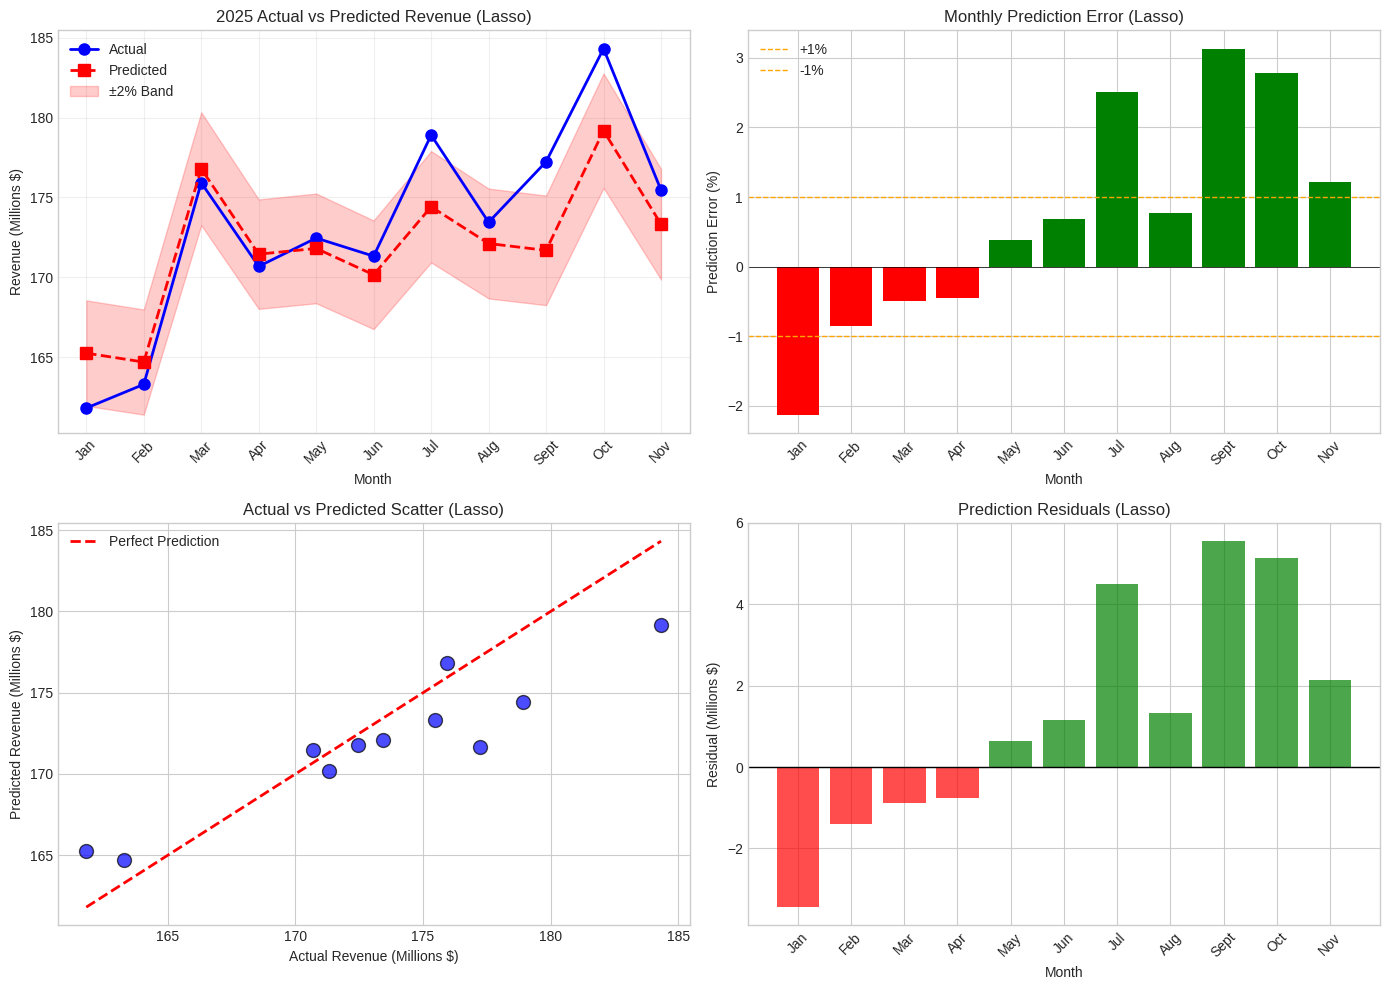

In [64]:
# Visualize predictions vs actual for Lasso model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted Line Chart
ax1 = axes[0, 0]
months = prediction_df_lasso['Month'].values
ax1.plot(months, prediction_df_lasso['Actual_Revenue']/1e6, 'b-o', label='Actual', linewidth=2, markersize=8)
ax1.plot(months, prediction_df_lasso['Predicted_Revenue']/1e6, 'r--s', label='Predicted', linewidth=2, markersize=8)
ax1.fill_between(months,
                  prediction_df_lasso['Predicted_Revenue']/1e6 * 0.98,
                  prediction_df_lasso['Predicted_Revenue']/1e6 * 1.02,
                  alpha=0.2, color='red', label='±2% Band')
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (Millions $)')
ax1.set_title('2025 Actual vs Predicted Revenue (Lasso)')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Error Distribution
ax2 = axes[0, 1]
ax2.bar(months, prediction_df_lasso['Pct_Error'], color=['green' if e > 0 else 'red' for e in prediction_df_lasso['Pct_Error']])
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='orange', linestyle='--', linewidth=1, label='+1%')
ax2.axhline(y=-1, color='orange', linestyle='--', linewidth=1, label='-1%')
ax2.set_xlabel('Month')
ax2.set_ylabel('Prediction Error (%)')
ax2.set_title('Monthly Prediction Error (Lasso)')
ax2.legend()
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Scatter Plot
ax3 = axes[1, 0]
ax3.scatter(prediction_df_lasso['Actual_Revenue']/1e6, prediction_df_lasso['Predicted_Revenue']/1e6,
           s=100, alpha=0.7, c='blue', edgecolors='black')
min_val_lasso = min(prediction_df_lasso['Actual_Revenue'].min(), prediction_df_lasso['Predicted_Revenue'].min())/1e6
max_val_lasso = max(prediction_df_lasso['Actual_Revenue'].max(), prediction_df_lasso['Predicted_Revenue'].max())/1e6
ax3.plot([min_val_lasso, max_val_lasso], [min_val_lasso, max_val_lasso], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Revenue (Millions $)')
ax3.set_ylabel('Predicted Revenue (Millions $)')
ax3.set_title('Actual vs Predicted Scatter (Lasso)')
ax3.legend()

# 4. Residuals
ax4 = axes[1, 1]
residuals_lasso = prediction_df_lasso['Difference']/1e6
ax4.bar(months, residuals_lasso, color=['green' if r > 0 else 'red' for r in residuals_lasso], alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Month')
ax4.set_ylabel('Residual (Millions $)')
ax4.set_title('Prediction Residuals (Lasso)')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('prediction_analysis_lasso.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 12 (Lasso): Yearly Forecast with Confidence Intervals

In [65]:
print("="*60)
print("YEARLY REVENUE FORECAST WITH RANGE (LASSO)")
print("="*60)

# Calculate yearly totals
actual_yearly_2025 = y_test.sum()
predicted_yearly_2025_lasso = y_pred_final_lasso.sum()

# Calculate prediction uncertainty based on model errors
monthly_errors_lasso = prediction_df_lasso['Abs_Pct_Error'].values
mean_error_lasso = monthly_errors_lasso.mean()
std_error_lasso = monthly_errors_lasso.std()

# Calculate confidence intervals (using bootstrapped approach)
n_bootstrap = 1000
yearly_predictions_lasso = []

for _ in range(n_bootstrap):
    # Add random noise based on observed error distribution
    noise_lasso = np.random.normal(0, std_error_lasso/100, len(y_pred_final_lasso))
    pred_with_noise_lasso = y_pred_final_lasso * (1 + noise_lasso)
    yearly_predictions_lasso.append(pred_with_noise_lasso.sum())

yearly_predictions_lasso = np.array(yearly_predictions_lasso)

# Calculate confidence intervals
ci_lower_90_lasso = np.percentile(yearly_predictions_lasso, 5)
ci_upper_90_lasso = np.percentile(yearly_predictions_lasso, 95)
ci_lower_95_lasso = np.percentile(yearly_predictions_lasso, 2.5)
ci_upper_95_lasso = np.percentile(yearly_predictions_lasso, 97.5)

print(f"\n2025 Yearly Revenue Forecast (Lasso):")
print(f"  Actual (so far):     ${actual_yearly_2025:>15,.0f}")
print(f"  Predicted:           ${predicted_yearly_2025_lasso:>15,.0f}")
print(f"  Difference:          ${actual_yearly_2025 - predicted_yearly_2025_lasso:>15,.0f}")
print(f"")
print(f"  90% Confidence Range: ${ci_lower_90_lasso:>12,.0f} - ${ci_upper_90_lasso:,.0f}")
print(f"  95% Confidence Range: ${ci_lower_95_lasso:>12,.0f} - ${ci_upper_95_lasso:,.0f}")

YEARLY REVENUE FORECAST WITH RANGE (LASSO)

2025 Yearly Revenue Forecast (Lasso):
  Actual (so far):     $  1,904,852,961
  Predicted:           $  1,890,864,654
  Difference:          $     13,988,306

  90% Confidence Range: $1,881,787,143 - $1,899,304,672
  95% Confidence Range: $1,880,314,443 - $1,901,048,388


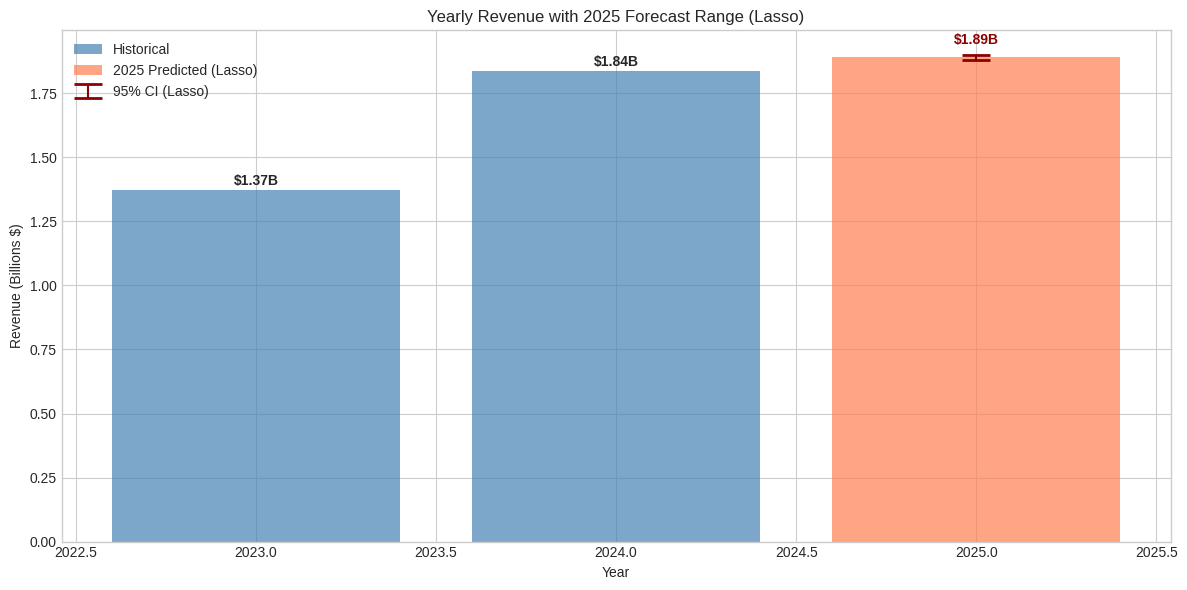

In [66]:
# Visualize yearly forecast with range for Lasso
fig, ax = plt.subplots(figsize=(12, 6))

years = yearly_summary.index.tolist()
totals = yearly_summary['Total_Revenue'].values

# Plot bars
bars = ax.bar(years[:-1], totals[:-1]/1e9, color='steelblue', alpha=0.7, label='Historical')
ax.bar([2025], [predicted_yearly_2025_lasso/1e9], color='coral', alpha=0.7, label='2025 Predicted (Lasso)')

# Add confidence interval
ax.errorbar([2025], [predicted_yearly_2025_lasso/1e9],
            yerr=[[(predicted_yearly_2025_lasso - ci_lower_95_lasso)/1e9], [(ci_upper_95_lasso - predicted_yearly_2025_lasso)/1e9]],
            fmt='none', color='darkred', capsize=10, capthick=2, label='95% CI (Lasso)')

ax.set_xlabel('Year')
ax.set_ylabel('Revenue (Billions $)')
ax.set_title('Yearly Revenue with 2025 Forecast Range (Lasso)')
ax.legend()

# Add value labels
for i, (year, total) in enumerate(zip(years[:-1], totals[:-1])):
    ax.text(year, total/1e9 + 0.02, f'${total/1e9:.2f}B', ha='center', fontweight='bold')
ax.text(2025, predicted_yearly_2025_lasso/1e9 + 0.05, f'${predicted_yearly_2025_lasso/1e9:.2f}B', ha='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('yearly_forecast_lasso.png', dpi=150, bbox_inches='tight')
plt.show()

---
## STEP 13 (Lasso): Human Forecast Validator - Delta Analysis

In [67]:
print("="*60)
print("HUMAN FORECAST VALIDATOR - DELTA ANALYSIS (LASSO)")
print("="*60)

# Re-use the simulated human forecasts
# human_forecasts = y_test.values * (1 + np.random.uniform(-0.05, 0.05, len(y_test))) # Already generated

# Create validation dataframe for Lasso model
validation_df_lasso = pd.DataFrame({
    'Year': test_data['year'].values,
    'Month': test_data['month'].values,
    'Actual_Revenue': y_test.values,
    'Human_Forecast': human_forecasts,
    'ML_Prediction_Lasso': y_pred_final_lasso,
})

# Calculate deltas
validation_df_lasso['Human_Delta'] = validation_df_lasso['Actual_Revenue'] - validation_df_lasso['Human_Forecast']
validation_df_lasso['ML_Delta_Lasso'] = validation_df_lasso['Actual_Revenue'] - validation_df_lasso['ML_Prediction_Lasso']
validation_df_lasso['Human_Pct_Error'] = (validation_df_lasso['Human_Delta'] / validation_df_lasso['Actual_Revenue'] * 100)
validation_df_lasso['ML_Pct_Error_Lasso'] = (validation_df_lasso['ML_Delta_Lasso'] / validation_df_lasso['Actual_Revenue'] * 100)
validation_df_lasso['ML_Better_Lasso'] = np.abs(validation_df_lasso['ML_Delta_Lasso']) < np.abs(validation_df_lasso['Human_Delta'])

print("\nMonthly Comparison - Human vs ML (Lasso) Predictions:")
print("="*120)
print(f"{'Month':<6} | {'Actual':>14} | {'Human Fcst':>14} | {'ML Pred (Lasso)':>14} | {'Human Err':>10} | {'ML Err (Lasso)':>10} | {'Better':>8}")
print("-"*120)

for _, row in validation_df_lasso.iterrows():
    better = "ML" if row['ML_Better_Lasso'] else "Human"
    print(f"{row['Month']:<6} | ${row['Actual_Revenue']:>13,.0f} | ${row['Human_Forecast']:>13,.0f} | "
          f"${row['ML_Prediction_Lasso']:>13,.0f} | {row['Human_Pct_Error']:>9.2f}% | {row['ML_Pct_Error_Lasso']:>9.2f}% | {better:>8}")

HUMAN FORECAST VALIDATOR - DELTA ANALYSIS (LASSO)

Monthly Comparison - Human vs ML (Lasso) Predictions:
Month  |         Actual |     Human Fcst | ML Pred (Lasso) |  Human Err | ML Err (Lasso) |   Better
------------------------------------------------------------------------------------------------------------------------
Jan    | $  161,804,911 | $  159,774,909 | $  165,246,485 |      1.25% |     -2.13% |    Human
Feb    | $  163,289,164 | $  170,648,841 | $  164,686,547 |     -4.51% |     -0.86% |       ML
Mar    | $  175,925,228 | $  180,006,587 | $  176,797,834 |     -2.32% |     -0.50% |       ML
Apr    | $  170,681,266 | $  172,365,181 | $  171,446,973 |     -0.99% |     -0.45% |       ML
May    | $  172,455,904 | $  166,523,742 | $  171,807,163 |      3.44% |      0.38% |       ML
Jun    | $  171,322,481 | $  165,428,894 | $  170,155,958 |      3.44% |      0.68% |       ML
Jul    | $  178,908,146 | $  171,001,901 | $  174,416,948 |      4.42% |      2.51% |       ML
Aug    | 

In [68]:
# Summary statistics for Lasso validation
print("\n" + "="*60)
print("VALIDATION SUMMARY (LASSO)")
print("="*60)

human_mape_lasso_summary = np.abs(validation_df_lasso['Human_Pct_Error']).mean()
ml_mape_lasso_summary = np.abs(validation_df_lasso['ML_Pct_Error_Lasso']).mean()

human_rmse_lasso_summary = np.sqrt((validation_df_lasso['Human_Delta']**2).mean())
ml_rmse_lasso_summary = np.sqrt((validation_df_lasso['ML_Delta_Lasso']**2).mean())

print(f"\nHuman Analyst Performance:")
print(f"  MAPE: {human_mape_lasso_summary:.2f}%")
print(f"  RMSE: ${human_rmse_lasso_summary:,.0f}")

print(f"\nML Model (Lasso) Performance:")
print(f"  MAPE: {ml_mape_lasso_summary:.2f}%")
print(f"  RMSE: ${ml_rmse_lasso_summary:,.0f}")

print(f"\nML vs Human Improvement (Lasso):")
print(f"  MAPE Improvement: {((human_mape_lasso_summary - ml_mape_lasso_summary) / human_mape_lasso_summary * 100):.1f}%")
print(f"  RMSE Improvement: {((human_rmse_lasso_summary - ml_rmse_lasso_summary) / human_rmse_lasso_summary * 100):.1f}%")
print(f"  Months where ML (Lasso) was better: {validation_df_lasso['ML_Better_Lasso'].sum()} / {len(validation_df_lasso)}")


VALIDATION SUMMARY (LASSO)

Human Analyst Performance:
  MAPE: 2.90%
  RMSE: $5,553,279

ML Model (Lasso) Performance:
  MAPE: 1.40%
  RMSE: $3,025,584

ML vs Human Improvement (Lasso):
  MAPE Improvement: 51.7%
  RMSE Improvement: 45.5%
  Months where ML (Lasso) was better: 8 / 11


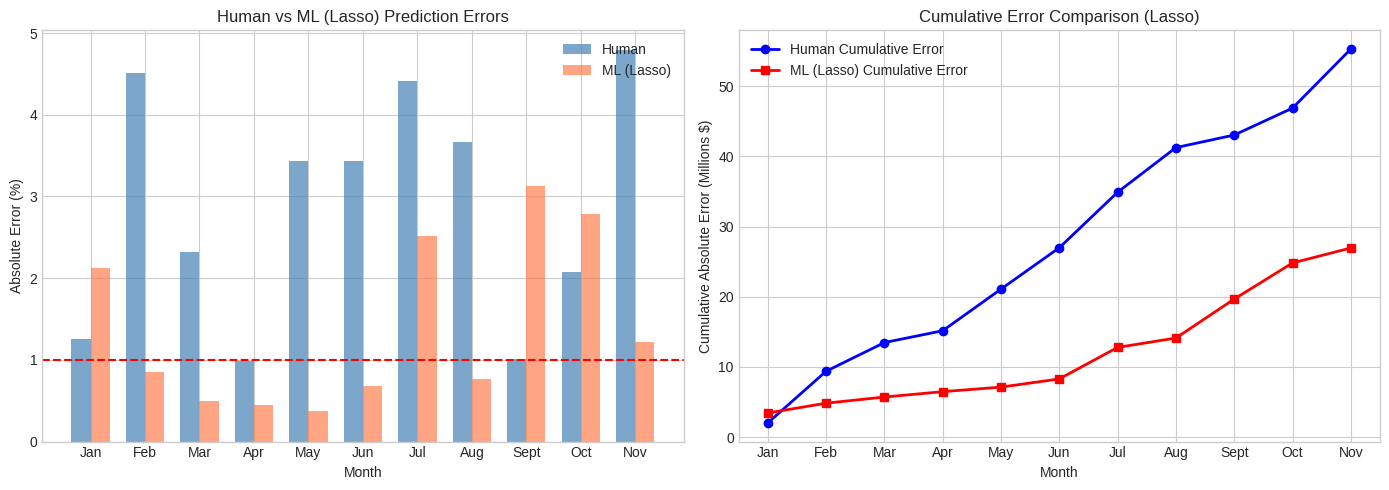

In [69]:
# Visualize validation comparison for Lasso
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error comparison
ax1 = axes[0]
x = np.arange(len(validation_df_lasso))
width = 0.35

ax1.bar(x - width/2, np.abs(validation_df_lasso['Human_Pct_Error']), width, label='Human', color='steelblue', alpha=0.7)
ax1.bar(x + width/2, np.abs(validation_df_lasso['ML_Pct_Error_Lasso']), width, label='ML (Lasso)', color='coral', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Absolute Error (%)')
ax1.set_title('Human vs ML (Lasso) Prediction Errors')
ax1.set_xticks(x)
ax1.set_xticklabels(validation_df_lasso['Month'])
ax1.legend()
ax1.axhline(y=1, color='red', linestyle='--', label='1% Target')

# Cumulative error
ax2 = axes[1]
ax2.plot(validation_df_lasso['Month'], np.abs(validation_df_lasso['Human_Delta']).cumsum()/1e6,
         'b-o', label='Human Cumulative Error', linewidth=2)
ax2.plot(validation_df_lasso['Month'], np.abs(validation_df_lasso['ML_Delta_Lasso']).cumsum()/1e6,
         'r-s', label='ML (Lasso) Cumulative Error', linewidth=2)
ax2.set_xlabel('Month')
ax2.set_ylabel('Cumulative Absolute Error (Millions $)')
ax2.set_title('Cumulative Error Comparison (Lasso)')
ax2.legend()

plt.tight_layout()
plt.savefig('validation_comparison_lasso.png', dpi=150, bbox_inches='tight')
plt.show()